In [1]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer
from utils import prepare_device
from experiments import get_experiment_config

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
args = argparse.ArgumentParser(description='PyTorch Template')
args.add_argument('-c', '--config', default=None, type=str,
                      help='config file path (default: None)')
args.add_argument('-r', '--resume', default=None, type=str,
                      help='path to latest checkpoint (default: None)')
args.add_argument('-d', '--device', default=None, type=str,
                  help='indices of GPUs to enable (default: all)')
# args.add_argument("-e", "--exp", type=int, required=True, help="Experiment id")
# args
# args.c = "config.json"
# 

args = args.parse_args(['-c','config.json',])
args.exp = 0
# batch_size = 10_000
print(args)
print(type(args))
config = ConfigParser.from_args(args)
config = get_experiment_config(config, config['id'])
# config['data_loader']['args']["additional_feature_names"] =  []
print(config.__dict__)

Namespace(config='config.json', resume=None, device=None, exp=0)
<class 'argparse.Namespace'>
Experiment 0 / 112:
                USE_ECG: True
                USE_HRV: True
                USE_FEATURES: True
                HRV_DURATION: 5m
                ECG_DURATION: 30s
                ADDITIONAL_FEATURES: ['newmultifracs', 'shannon_encoding', 'autoreg']                
{'_config': OrderedDict([('name', 'MyTraining'), ('n_gpu', 1), ('arch', OrderedDict([('type', 'MyModel'), ('args', OrderedDict([('use_ecg_time_series', True), ('use_hrv_time_series', True), ('use_features', True)]))])), ('data_loader', OrderedDict([('type', 'MyDataLoader'), ('args', OrderedDict([('data_dir', 'data/data_patient'), ('batch_size', 32), ('shuffle', True), ('validation_split', 0.2), ('num_workers', 2), ('features_duration', '5m'), ('hrv_duration', '5m'), ('ecg_duration', '30s'), ('additional_feature_names', ['newmultifracs', 'shannon_encoding', 'autoreg'])]))])), ('optimizer', OrderedDict([('type', 'Ada

In [4]:
# data_loader.dataset.get_feature_size()

In [5]:
data_loader = config.init_obj('data_loader', module_data)

In [6]:
# data_loader = getattr(module_data, config['data_loader']['type'])(
#         config['data_loader']['args']['data_dir'],
#         batch_size=512,
#         shuffle=False,
#         validation_split=0.0,
#         training=False,
#         num_workers=2
#     )

config['arch']['args']['feature_size'] = data_loader.dataset.get_feature_size()
config['arch']['args']['num_classes'] = data_loader.dataset.get_num_classes()

# build model architecture
model = config.init_obj('arch', module_arch)
# logger.info(model)

# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

# logger.info('Loading checkpoint: {} ...'.format(config.resume))
checkpoint = torch.load("saved/models/MyTraining/0/0926_144845/model_best.pth") # config.resume)
state_dict = checkpoint['state_dict']
# if config['n_gpu'] > 1:
#     model = torch.nn.DataParallel(model)
# state_dict = 
model.load_state_dict(state_dict)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()



MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hrv_conv): ConvNet(
    (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
    (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv5): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv6): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv7): Conv1d(32, 256, kernel_size=(3,), stride=(1,))
    (conv8): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (global_maxpool): AdaptiveMaxPool1d(output_size=1)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=256, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
  )
  (ecg_conv): ConvNe

In [7]:
total_loss = 0.0
total_metrics = torch.zeros(len(metric_fns))

outputs = []
inputs = []
inputs_ecg = []
inputs_hrv = []
outputs1 = []
outputs2 = []
outputs3 = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(data_loader)):
        # data, target = data.to(device), target.to(device)

        out1 = model.flatten(model.ecg_conv(data["ecg_time_series"]))
        out2 = model.flatten(model.hrv_conv(data["hrv_time_series"]))

        features = model.features(data["features"])
    
        concat = torch.cat([model.flatten(out1), model.flatten(out2), features],dim=-1)
        outputs.append(concat)
        
        labels.append(target)
        inputs.append(data)
        inputs_ecg.append(data["ecg_time_series"])
        inputs_hrv.append(data["hrv_time_series"])
        outputs1.append(out1)
        outputs2.append(out2)
        outputs3.append(features)
        #
        # save sample images, or do something with output here
        #

        # computing loss, metrics on test set
        # loss = loss_fn(output, target)
        # batch_size = data.shape[0]
        # total_loss += loss.item() * batch_size
        # for i, metric in enumerate(metric_fns):
        #     total_metrics[i] += metric(output, target) * batch_size

# inputs = torch.cat(inputs)
inputs_ecg = torch.cat(inputs_ecg,dim=0)
inputs_hrv = torch.cat(inputs_hrv,dim=0)
outputs = torch.cat(outputs,dim=0)
outputs1 = torch.cat(outputs1,dim=0)
outputs2 = torch.cat(outputs2,dim=0)
outputs3 = torch.cat(outputs3,dim=0)

labels = torch.cat(labels,dim=0)
labels = np.array(labels)

100%|██████████| 161/161 [00:39<00:00,  4.11it/s]


## Entropy estimation

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [9]:
import numpy as np
import math

import torch
import torch.nn as nn


In [10]:
from model.my_model import ConvNet
import copy

In [11]:
class MyDataset(Dataset):

    def __init__(self, X, Y, labels):
        self.X = X
        self.Y = Y
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return the features and corresponding label at the given index
        return self.X[idx], self.Y[idx], self.labels[idx]

In [12]:
dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))

In [13]:
from sklearn.feature_selection import mutual_info_classif

In [14]:
X,y,label = dataset[:]
X = np.array(X).squeeze()
y = np.array(y)
label = np.array(label)


In [15]:
X.shape

(5140, 3840)

In [16]:
res = mutual_info_classif(X,label)

In [18]:
for n in [3,10,50,100,300]:
    res = mutual_info_classif(y,label,n_neighbors=n)
    print(res)
    print(res.mean())

[0.6404705  0.57393381 0.61927569 0.58060789 0.59413071 0.50187154
 0.60830378 0.62696188 0.32441916 0.53262602 0.61225841 0.74059727
 0.48948113 0.59043673 0.54220141 0.45538354 0.37147048 0.50280187
 0.30205925 0.27534448 0.56806143 0.68974686 0.57530696 0.56609478
 0.66276285 0.72381776 0.79170604 0.69976952 0.35594996 0.53310458
 0.73651443 0.25047196]
0.5511857096775474
[0.63384949 0.56602845 0.6289287  0.58991649 0.60558246 0.51296952
 0.60294843 0.62982341 0.31535674 0.53276119 0.61623834 0.74128486
 0.48993895 0.58747691 0.54789223 0.46922131 0.35509732 0.50283769
 0.3025302  0.27304373 0.56164058 0.69962279 0.57169637 0.55783955
 0.66442238 0.71077282 0.78734242 0.70015154 0.35402105 0.53259765
 0.73623339 0.24535914]
0.5507945652957595
[0.63953696 0.57240928 0.63758452 0.59612831 0.61130032 0.51819036
 0.61575303 0.63328438 0.31412404 0.54161889 0.62323628 0.75339921
 0.49606786 0.59351975 0.55951108 0.48407816 0.35615827 0.50150089
 0.29434321 0.28054456 0.57796053 0.7098412

In [28]:
%pip install dtw-python

  Obtaining dependency information for dtw-python from https://files.pythonhosted.org/packages/32/9f/e0b91a75a810bec321909ed910ee5fca7ba6b7808f5e0f389d90d46623e8/dtw_python-1.5.3-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/49.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/49.0 kB ? eta -:--:--
     ----------------------- -------------- 30.7/49.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 49.0/49.0 kB 355.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/376.2 kB ? eta -:--:--
   ---- ----------------------------------- 41.0/376.2 kB 2.0 MB/s eta 0:00:01
   ----------------------- ---------------- 225.3/376.2 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 376.2/376.2 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\aejog\anaconda3\lib\site-packages\appdirs-1.4.4-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\aejog\anaconda3\lib\site-packages\kymatio-0.4.0.dev0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [31]:
import numpy as np
from dtw import dtw

# Example sequences
sequence1 = np.array([0, 1, 2, 3, 4, 5])
sequence2 = np.array([1, 2, 3, 4, 5, 6])

# Define a distance function (Euclidean distance is commonly used)
def euclidean_distance(x, y):
    return np.abs(x - y)

# Perform DTW
alignment = dtw(sequence1, sequence2)

# Display the alignment distance
print("DTW distance:", alignment.distance)

DTW distance: 2.0


In [26]:
#! /usr/bin/env python3
""" Python implementation of the mutual information estimator proposed by
Ross, 2014, "Mutual Information between Discrete and Continuous Data Sets",
PLOS One. Computes mutual information between a continuous multidimensional
variable and a discrete (categorical) variable, from an array of samples.

The formula for this estimator is
    $$ MI(X, Y) = psi(N) - <psi(N_x)> + psi(k) - <psi(m)> $$
where:
    - psi is the digamma function;
    - N is the number of points;
    - N_x is the number of points of category X=x;
    - k is the number of nearest-neighbors of the same category used to
        estimate the probability density;
    - m is the number of nearest-neighbors of any category within the ball
        extending up to the kth nearest-neighbor of the same category x;
    - <psi(N_x)> and <psi(m)> are averaged over samples of X (each category
        X=x is weighted by the number of occurences of x);

Speed improved by vectorizing some operations, using Scipy's cKDTree
for nearest-neighbor search, and using its multi-code capabilities.
Includes a direct translation in Python of the original Matlab code
provided by Ross 2014, for comparison (it is slower).

WARNING: limited testing of the code was carried out. It worked fine on the
test case provided below and for the authors' use cases, but results are not
guaranteed in other applications (especially with very high-dimensional data).

@authors: François Bourassa (frbourassa), Sooraj Achar (soorajachar)
Spring 2021
"""

import numpy as np
from scipy import special
from scipy.spatial import cKDTree
import psutil


def discrete_continuous_info_fast(d, c, k=3, base=np.e, eps=0):
    """
    Estimates mutual information between a discrete vector d and a continuous
    vector c (can be multidimensional) using nearest-neighbor statistics.
    Relatively fast Python implementation, using Scipy's cKDTree, of the
    estimator described by Ross, 2014, "Mutual Information between Discrete
    and Continuous Data Sets", PLOS One.
    Similar to the estimator described by Kraskov et al., 2004,
    "Estimating Mutual Information", PRE.

    Author of this implementation: Francois Bourassa (Github: frbourassa)

    Args:
        d (np.array): Array of discrete categories. Should be 1-dimensional
        c (np.array): Two-dimensional array or matrix of the continuous data.
            Dimensions should be (n samples x f features)
        k (int): Number of nearest neighbors for density estimation
        base (float): Logarithm base in which the MI is computed (default: e)
        eps (float): Relative tolerance on the radius up to which neighbors
            are included (default: 0, exact computation).

    Returns:
        float: Mutual information estimate
    """
    # Make sure d is an array to allow use of numpy functions
    if type(d) is list:
        d = np.asarray(d, dtype=type(d[0]))
    if d.ndim > 1:
        raise TypeError("d should be a 1d list or array")

    # First, prepare a list of categories according to the discrete symbols d
    numDimensions = c.shape[0]
    categories = list(np.unique(d))
    num_d_symbols = len(categories)

    # Build a KDTree of all points
    main_tree = cKDTree(c, leafsize=max(16, int(k*numDimensions/4)))

    # Number of workers for parallel processing, use half of them.
    n_workers = min(1, psutil.cpu_count() // 2)

    # Check that there are no exactly identical points
    identical_pairs = main_tree.query_pairs(r=0.0, eps=0.0, output_type="ndarray")
    # If any, perturb them slightly to avoid numerical instabilities
    dup_pts = np.unique(identical_pairs[:, 0])
    if identical_pairs.shape[0] > 0:
        # Average nn distance as a perturbation
        perturb = 1e-6*np.mean(main_tree.query(c, k=[2])[0])
        # Perturb the first point of each pair
        c[dup_pts, :] = c[dup_pts, :] + perturb*(np.random.random(size=(dup_pts.shape[0], c.shape[1])) - 0.5)
        # Update the tree
        main_tree = cKDTree(c, leafsize=max(16, int(k*numDimensions/4)))

    # Build an internal tree for each category
    m_tot = 0
    av_psi_Nd = 0
    psi_ks = 0
    for c_bin in range(num_d_symbols):
         # Slice elements in that category, save indices
        ii = (d == categories[c_bin]).nonzero()
        c_split = c[ii]
        numSamplesInBin = c_split.shape[0]
        one_k = min(k, numSamplesInBin-1)

        # For each point in the category, find the radius to its kth
        # nearest-neighbor, and count how many points of any category
        # are in that radius.
        if one_k > 0:
            # Build KDTree with leaf size one_k+2, since we won't need
            # to go much further
            categ_tree = cKDTree(c_split, leafsize=16)

            # Go to one_k+1 because self point is included as a neighbors.
            radii, indices = categ_tree.query(
                                c_split, [one_k+1], eps=eps, workers=n_workers)

            # For each, count how many total points are within that distance.
            # Increase radii a little bit to make sure at least the one_k
            # neighbours in the category are found back
            # (float comparison issues in query in a different tree otherwise)
            m_points_all = main_tree.query_ball_point(
                                c_split, radii.ravel()*(1+1e-15), eps=eps,
                                workers=n_workers, return_length=True)
            m_points_all -= 1  # the query includes the point itself

            # m_tot is \sum_i (psi(m_i))
            m_tot = m_tot + np.sum(special.psi(m_points_all))

        else:  # There was a single point in the category.
            m_tot = m_tot + special.psi(num_d_symbols*2)

        # Probability of each category given by its relative abundance in d
        p_d = numSamplesInBin/len(d)
        # Running estimates of the average digamma terms in the estimator
        av_psi_Nd += p_d*special.psi(p_d*len(d))
        psi_ks = psi_ks + p_d * special.psi(max(one_k, 1))
    # Computing the estimator
    f = special.psi(len(d)) - av_psi_Nd + psi_ks - m_tot/len(d)
    return f / np.log(base)


def discrete_continuous_info_ref(d, c, k=3, base=np.exp(1)):
    """
    Estimates the mutual information between a discrete vector 'd' and a
    continuous vector 'c' using nearest-neighbor statistics.
    Python translation of the estimator coded in Matlab
    Ross, 2014, https://doi.org/10.1371/journal.pone.0087357
    Similar to the estimator proposed by Kraskov et al., 2004,
    "Estimating Mutual Information", PRE.

    Author of the translation: Sooraj Achar (Github: soorajachar)

    Parameters:
        d (np.array): List of discrete categories. Should be 1 dimensional
        c (np.matrix): Matrix of continuous data.
            Dimensions should be n samples x f features
        k (int): Number of nearest neighbors
        base (float): Logarithm base in which the MI is computed (default: e)

    Returns:
        float: Mutual information estimate
    """
    #Make sure d is an array to allow use of numpy functions
    if type(d) is list:
        d = np.array(d, dtype=str)
    #Remove eventually
    if c.shape[1] < c.shape[0]:
        c = c.T
    first_symbol = []
    symbol_IDs = np.zeros(len(d))
    c_split = []
    cs_indices = []
    num_d_symbols = -1
    #First, bin the continuous data "c" according to the discrete symbols "d"
    numDimensions = c.shape[0]
    categories = list(np.unique(d))
    num_d_symbols = len(categories)
    for category in categories:
        ii = np.where(d == category)[0]
        cs_indices.append(ii)
        #Flip later
        c_split.append(c[:, ii])

    m_tot = 0
    av_psi_Nd = 0
    all_c_distances = np.zeros(len(d))
    psi_ks = 0
    for c_bin in range(num_d_symbols):
        numSamplesInBin = c_split[c_bin].shape[1]
        one_k = min(k, numSamplesInBin-1)
        if one_k > 0:
            c_distances = np.zeros([numSamplesInBin])
            for pivot in range(numSamplesInBin):
                # find the radius of our volume using only those samples with
                # the particular value of the discrete symbol 'd'
                for cv in range(numSamplesInBin):
                    vec_diff = (c_split[c_bin][:, cv]
                                    - c_split[c_bin][:, pivot])
                    vec_diff = np.reshape(vec_diff, (-1, c.shape[0])).T
                    c_distances[cv] = np.sqrt(np.dot(vec_diff.T, vec_diff))
                sorted_distances = np.sort(c_distances)
                eps_over_2 = sorted_distances[one_k]   # don't count pivot

                #count the number of total samples within our volume using all
                #  samples (all values of 'd')
                for cv in range(c.shape[1]):
                    vec_diff = c[:, cv] - c_split[c_bin][:, pivot]
                    vec_diff = np.reshape(vec_diff, (-1, c.shape[0])).T
                    all_c_distances[cv] = np.sqrt(np.dot(vec_diff.T, vec_diff))
                # Don't count pivot point
                neigh_all_categs = np.where(all_c_distances <= eps_over_2)
                m = max(len(all_c_distances[neigh_all_categs]) - 1, 0)
                m_tot = m_tot + special.psi(m)

        else:
            m_tot = m_tot + special.psi(num_d_symbols*2)

        p_d = numSamplesInBin/len(d)
        av_psi_Nd = av_psi_Nd + p_d*special.psi(p_d*len(d))
        psi_ks = psi_ks + p_d * special.psi(max(one_k, 1))

    f = special.psi(len(d)) - av_psi_Nd + psi_ks - m_tot/len(d)
    return f / np.log(base)


# if __name__ == "__main__":
#     # Some test case to make sure both approaches work the same way
#     # nsamp = 50
#     # data = np.zeros([nsamp*4, 2])
#     # target = np.zeros(nsamp*4)
#     # rndgen = np.random.default_rng(seed=12323452)
#     # for i in range(4):
#     #     mean = np.asarray([i, i])
#     #     cov = np.eye(2)*(i+1)*0.75
#     #     data[nsamp*i:nsamp*(i+1)] = rndgen.multivariate_normal(
#     #                                         mean=mean, cov=cov, size=nsamp)
#     #     target[nsamp*i:nsamp*(i+1)] = i
#     target = labels
#     print(target.shape)
#     data = X
#     # Reference algorithm with for loops
#     mi_ref = discrete_continuous_info_ref(target, data, k=3, base=2)
#     print("Reference MI = ", mi_ref)

#     # Fast, approximate algorithm using KDTrees and vectorized queries
#     mi_fast = discrete_continuous_info_fast(target, data, k=3, base=2)
#     msg = "Difference too large to be true: found "+str(mi_fast)
#     assert abs(mi_ref - mi_fast) < 1e-10, msg
#     print("Fast MI = ", mi_fast)


In [34]:
y

array([[-1.0036287 , -0.33342677, -0.7028649 , ..., -0.02573977,
         0.37117124,  0.02566248],
       [-0.8337579 ,  0.35795164, -0.73773265, ...,  0.0935782 ,
         0.74977994,  0.07879715],
       [-0.934284  ,  0.2652989 , -0.62785053, ...,  0.01784897,
         0.8059541 ,  0.14918669],
       ...,
       [ 0.7639055 ,  0.04372032,  0.6465986 , ...,  0.9228038 ,
        -0.49429268,  0.39612967],
       [-0.6291675 ,  0.14245938, -0.36647016, ..., -0.02929656,
         0.5634943 ,  0.10434194],
       [-0.751663  , -0.10784094, -0.36594906, ...,  0.05336997,
         0.1765241 ,  0.31795323]], dtype=float32)

In [33]:
target = labels
print(target.shape)
data = y
# # Reference algorithm with for loops
mi_ref = discrete_continuous_info_ref(target, data, k=10, base=2)
print("Reference MI = ", mi_ref)

# Fast, approximate algorithm using KDTrees and vectorized queries
mi_fast = discrete_continuous_info_fast(target, data, k=10, base=2,eps=1e-5)
msg = "Difference too large to be true: found "+str(mi_fast)
assert abs(mi_ref - mi_fast) < 1e-10, msg
print("Fast MI = ", mi_fast)

(5140,)
Reference MI =  1.4995459098992576
Fast MI =  1.499545909899439


In [43]:
convnet = copy.deepcopy(model.ecg_conv)

In [47]:
class MINE(nn.Module):
    def __init__(self,zd_dim):
        super(MINE, self).__init__()
        self.convnet = convnet
        self.net = nn.Sequential(nn.Linear(32+zd_dim,64),nn.ReLU(),nn.Linear(64,32),nn.ReLU(),nn.Linear(32,1))#FF(args, zc_dim + zd_dim, zc_dim, 1)

    def forward(self, z_c, z_d,y=0):  # samples have shape [sample_size, dim]
        # shuffle and concatenate
        z_c = self.convnet(z_c)
        sample_size = z_d.shape[0]
        random_index = torch.randint(sample_size, (sample_size,)).long()

        z_d_shuffle = z_d[random_index]

        T0 = self.net(torch.cat([z_c, z_d], dim=-1))
        T1 = self.net(torch.cat([z_c, z_d_shuffle], dim=-1))

        mi = T0.mean() - (T1.squeeze().logsumexp(0) - math.log(sample_size))
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d,y=0):
        return - self(z_c, z_d)[0]

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train  tensor(0.0225, grad_fn=<SubBackward0>)
train  tensor(0.0474, grad_fn=<SubBackward0>)
train  tensor(0.0475, grad_fn=<SubBackward0>)
train  tensor(0.0845, grad_fn=<SubBackward0>)
train  tensor(0.0564, grad_fn=<SubBackward0>)
train  tensor(0.1191, grad_fn=<SubBackward0>)
train  tensor(0.1043, grad_fn=<SubBackward0>)
train  tensor(0.1601, grad_fn=<SubBackward0>)
train  tensor(0.1715, grad_fn=<SubBackward0>)
train  tensor(0.1475, grad_fn=<SubBackward0>)
train  tensor(0.1595, grad_fn=<SubBackward0>)
train  tensor(0.2018, grad_fn=<SubBackward0>)
train  tensor(0.2275, grad_fn=<SubBackward0>)
train  tensor(0.2809, grad_fn=<SubBackward0>)
train  tensor(0.2333, grad_fn=<SubBackward0>)
train  tensor(0.2735, grad_fn=<SubBackward0>)
train  tensor(0.3085, grad_fn=<SubBackward0>)
train  tensor(0.3291, grad_fn=<SubBackward0>)
train  tensor(0.3373, grad_fn=<SubBackward0>)
train  tensor(0.3332, grad_fn=<SubBackward0>)
train  tensor(0.4975, grad_fn=<SubBackward0>)
train  tensor(0.3024, grad_fn=<Sub

epoch:   1%|          | 1/100 [01:02<1:43:12, 62.55s/it]

train  tensor(1.8628, grad_fn=<SubBackward0>)
train  tensor(1.3100, grad_fn=<SubBackward0>)
train  tensor(1.3799, grad_fn=<SubBackward0>)
train  tensor(1.2406, grad_fn=<SubBackward0>)
train  tensor(1.3254, grad_fn=<SubBackward0>)
train  tensor(1.3597, grad_fn=<SubBackward0>)
train  tensor(1.1981, grad_fn=<SubBackward0>)
train  tensor(1.1444, grad_fn=<SubBackward0>)
train  tensor(1.8681, grad_fn=<SubBackward0>)
train  tensor(1.3825, grad_fn=<SubBackward0>)
train  tensor(1.5520, grad_fn=<SubBackward0>)
train  tensor(1.3728, grad_fn=<SubBackward0>)
train  tensor(1.3725, grad_fn=<SubBackward0>)
train  tensor(1.2884, grad_fn=<SubBackward0>)
train  tensor(1.4614, grad_fn=<SubBackward0>)
train  tensor(1.5000, grad_fn=<SubBackward0>)
train  tensor(1.4561, grad_fn=<SubBackward0>)
train  tensor(1.2133, grad_fn=<SubBackward0>)
train  tensor(1.7527, grad_fn=<SubBackward0>)
train  tensor(1.6345, grad_fn=<SubBackward0>)
train  tensor(1.7599, grad_fn=<SubBackward0>)
train  tensor(1.8987, grad_fn=<Sub

epoch:   2%|▏         | 2/100 [02:06<1:43:18, 63.25s/it]

train  tensor(1.6833, grad_fn=<SubBackward0>)
train  tensor(0.5813, grad_fn=<SubBackward0>)
train  tensor(0.3765, grad_fn=<SubBackward0>)
train  tensor(0.0281, grad_fn=<SubBackward0>)
train  tensor(1.0561, grad_fn=<SubBackward0>)
train  tensor(0.1142, grad_fn=<SubBackward0>)
train  tensor(0.6251, grad_fn=<SubBackward0>)
train  tensor(0.2823, grad_fn=<SubBackward0>)
train  tensor(0.7904, grad_fn=<SubBackward0>)
train  tensor(1.1447, grad_fn=<SubBackward0>)
train  tensor(1.1175, grad_fn=<SubBackward0>)
train  tensor(1.3747, grad_fn=<SubBackward0>)
train  tensor(1.7677, grad_fn=<SubBackward0>)
train  tensor(2.3556, grad_fn=<SubBackward0>)
train  tensor(1.7998, grad_fn=<SubBackward0>)
train  tensor(1.0294, grad_fn=<SubBackward0>)
train  tensor(1.4995, grad_fn=<SubBackward0>)
train  tensor(1.7854, grad_fn=<SubBackward0>)
train  tensor(1.0725, grad_fn=<SubBackward0>)
train  tensor(1.3072, grad_fn=<SubBackward0>)
train  tensor(1.3151, grad_fn=<SubBackward0>)
test  tensor(1.3251)
test  tensor(

epoch:   3%|▎         | 3/100 [03:07<1:40:41, 62.29s/it]

train  tensor(1.6686, grad_fn=<SubBackward0>)
train  tensor(1.2274, grad_fn=<SubBackward0>)
train  tensor(1.1632, grad_fn=<SubBackward0>)
train  tensor(1.5318, grad_fn=<SubBackward0>)
train  tensor(1.8155, grad_fn=<SubBackward0>)
train  tensor(1.6461, grad_fn=<SubBackward0>)
test  tensor(1.3706)
test  tensor(1.7409)
test  tensor(1.9923)
test  tensor(1.5301)
test  tensor(1.8415)
test  tensor(1.8198)
test  tensor(1.4290)
test  tensor(1.5571)
test  tensor(1.0194)
test  tensor(1.9879)
test  tensor(1.5226)
test  tensor(1.3206)
test  tensor(2.0775)
test  tensor(1.3836)
test  tensor(1.8332)
test  tensor(1.5948)
test  tensor(2.3184)
train  tensor(1.6537, grad_fn=<SubBackward0>)
train  tensor(1.9589, grad_fn=<SubBackward0>)
train  tensor(1.5042, grad_fn=<SubBackward0>)
train  tensor(2.2375, grad_fn=<SubBackward0>)
train  tensor(1.0391, grad_fn=<SubBackward0>)
train  tensor(1.5873, grad_fn=<SubBackward0>)
train  tensor(1.0935, grad_fn=<SubBackward0>)
train  tensor(1.4470, grad_fn=<SubBackward0>)

epoch:   4%|▍         | 4/100 [04:10<1:40:23, 62.75s/it]

train  tensor(2.8845, grad_fn=<SubBackward0>)
train  tensor(2.1069, grad_fn=<SubBackward0>)
train  tensor(1.7134, grad_fn=<SubBackward0>)
train  tensor(1.9858, grad_fn=<SubBackward0>)
train  tensor(1.9023, grad_fn=<SubBackward0>)
train  tensor(1.7783, grad_fn=<SubBackward0>)
train  tensor(2.0121, grad_fn=<SubBackward0>)
train  tensor(2.0302, grad_fn=<SubBackward0>)
train  tensor(2.6350, grad_fn=<SubBackward0>)
train  tensor(2.5037, grad_fn=<SubBackward0>)
train  tensor(2.1190, grad_fn=<SubBackward0>)
train  tensor(2.1139, grad_fn=<SubBackward0>)
train  tensor(1.6834, grad_fn=<SubBackward0>)
train  tensor(1.7804, grad_fn=<SubBackward0>)
train  tensor(1.5365, grad_fn=<SubBackward0>)
train  tensor(2.0705, grad_fn=<SubBackward0>)
train  tensor(1.4345, grad_fn=<SubBackward0>)
train  tensor(1.2275, grad_fn=<SubBackward0>)
train  tensor(2.1800, grad_fn=<SubBackward0>)
train  tensor(1.6409, grad_fn=<SubBackward0>)
train  tensor(2.3562, grad_fn=<SubBackward0>)
train  tensor(1.3017, grad_fn=<Sub

epoch:   5%|▌         | 5/100 [05:10<1:37:43, 61.72s/it]

train  tensor(1.0034, grad_fn=<SubBackward0>)
train  tensor(0.9413, grad_fn=<SubBackward0>)
train  tensor(2.3160, grad_fn=<SubBackward0>)
train  tensor(2.7821, grad_fn=<SubBackward0>)
train  tensor(1.6383, grad_fn=<SubBackward0>)
train  tensor(1.3521, grad_fn=<SubBackward0>)
train  tensor(1.7366, grad_fn=<SubBackward0>)
train  tensor(1.7327, grad_fn=<SubBackward0>)
train  tensor(2.1880, grad_fn=<SubBackward0>)
train  tensor(2.1170, grad_fn=<SubBackward0>)
train  tensor(1.7435, grad_fn=<SubBackward0>)
train  tensor(2.9912, grad_fn=<SubBackward0>)
train  tensor(2.1718, grad_fn=<SubBackward0>)
train  tensor(1.9104, grad_fn=<SubBackward0>)
train  tensor(1.8553, grad_fn=<SubBackward0>)
train  tensor(1.3846, grad_fn=<SubBackward0>)
train  tensor(1.5853, grad_fn=<SubBackward0>)
train  tensor(1.6542, grad_fn=<SubBackward0>)
train  tensor(1.3444, grad_fn=<SubBackward0>)
train  tensor(1.2531, grad_fn=<SubBackward0>)
train  tensor(1.4909, grad_fn=<SubBackward0>)
train  tensor(1.9616, grad_fn=<Sub

epoch:   6%|▌         | 6/100 [06:10<1:35:22, 60.88s/it]

train  tensor(1.1063, grad_fn=<SubBackward0>)
train  tensor(1.6580, grad_fn=<SubBackward0>)
train  tensor(0.6831, grad_fn=<SubBackward0>)
train  tensor(1.3403, grad_fn=<SubBackward0>)
train  tensor(1.3742, grad_fn=<SubBackward0>)
train  tensor(2.1261, grad_fn=<SubBackward0>)
train  tensor(1.9628, grad_fn=<SubBackward0>)
train  tensor(3.0146, grad_fn=<SubBackward0>)
train  tensor(1.7492, grad_fn=<SubBackward0>)
train  tensor(1.4238, grad_fn=<SubBackward0>)
train  tensor(1.5067, grad_fn=<SubBackward0>)
test  tensor(2.1636)
test  tensor(1.7959)
test  tensor(2.3946)
test  tensor(1.6775)
test  tensor(2.2780)
test  tensor(2.1607)
test  tensor(2.5148)
test  tensor(2.0505)
test  tensor(2.2397)
test  tensor(2.3131)
test  tensor(1.8459)
test  tensor(2.2354)
test  tensor(2.1084)
test  tensor(2.0928)
test  tensor(2.1749)
test  tensor(2.2014)
test  tensor(2.1480)
train  tensor(1.8027, grad_fn=<SubBackward0>)
train  tensor(1.5774, grad_fn=<SubBackward0>)
train  tensor(2.1571, grad_fn=<SubBackward0>)

epoch:   7%|▋         | 7/100 [07:20<1:39:26, 64.15s/it]

train  tensor(1.7275, grad_fn=<SubBackward0>)
train  tensor(2.2309, grad_fn=<SubBackward0>)
train  tensor(0.9346, grad_fn=<SubBackward0>)
train  tensor(0.8532, grad_fn=<SubBackward0>)
train  tensor(1.5913, grad_fn=<SubBackward0>)
train  tensor(1.5704, grad_fn=<SubBackward0>)
train  tensor(2.3770, grad_fn=<SubBackward0>)
train  tensor(1.8788, grad_fn=<SubBackward0>)
train  tensor(1.6969, grad_fn=<SubBackward0>)
train  tensor(1.7491, grad_fn=<SubBackward0>)
train  tensor(1.7250, grad_fn=<SubBackward0>)
train  tensor(2.3220, grad_fn=<SubBackward0>)
train  tensor(1.3758, grad_fn=<SubBackward0>)
train  tensor(2.6532, grad_fn=<SubBackward0>)
train  tensor(1.6167, grad_fn=<SubBackward0>)
train  tensor(1.5968, grad_fn=<SubBackward0>)
train  tensor(2.2041, grad_fn=<SubBackward0>)
train  tensor(1.5177, grad_fn=<SubBackward0>)
train  tensor(2.6408, grad_fn=<SubBackward0>)
train  tensor(2.2958, grad_fn=<SubBackward0>)
train  tensor(2.1342, grad_fn=<SubBackward0>)
train  tensor(1.8624, grad_fn=<Sub

epoch:   8%|▊         | 8/100 [08:19<1:35:49, 62.50s/it]

train  tensor(1.3467, grad_fn=<SubBackward0>)
train  tensor(1.5013, grad_fn=<SubBackward0>)
train  tensor(1.2902, grad_fn=<SubBackward0>)
train  tensor(1.7757, grad_fn=<SubBackward0>)
train  tensor(0.4245, grad_fn=<SubBackward0>)
train  tensor(-0.1301, grad_fn=<SubBackward0>)
train  tensor(0.8232, grad_fn=<SubBackward0>)
train  tensor(2.3590, grad_fn=<SubBackward0>)
train  tensor(1.5077, grad_fn=<SubBackward0>)
train  tensor(3.5231, grad_fn=<SubBackward0>)
train  tensor(0.1405, grad_fn=<SubBackward0>)
train  tensor(2.4590, grad_fn=<SubBackward0>)
train  tensor(2.7356, grad_fn=<SubBackward0>)
train  tensor(1.7525, grad_fn=<SubBackward0>)
train  tensor(2.8249, grad_fn=<SubBackward0>)
train  tensor(1.7977, grad_fn=<SubBackward0>)
train  tensor(2.5680, grad_fn=<SubBackward0>)
train  tensor(2.3746, grad_fn=<SubBackward0>)
train  tensor(1.4947, grad_fn=<SubBackward0>)
train  tensor(1.6231, grad_fn=<SubBackward0>)
train  tensor(2.3556, grad_fn=<SubBackward0>)
train  tensor(1.4139, grad_fn=<Su

epoch:   9%|▉         | 9/100 [09:21<1:34:21, 62.22s/it]

train  tensor(1.2802, grad_fn=<SubBackward0>)
train  tensor(2.3366, grad_fn=<SubBackward0>)
train  tensor(2.1017, grad_fn=<SubBackward0>)
train  tensor(2.3451, grad_fn=<SubBackward0>)
train  tensor(1.8120, grad_fn=<SubBackward0>)
train  tensor(1.6418, grad_fn=<SubBackward0>)
train  tensor(1.5873, grad_fn=<SubBackward0>)
train  tensor(2.2685, grad_fn=<SubBackward0>)
train  tensor(2.6694, grad_fn=<SubBackward0>)
train  tensor(2.0112, grad_fn=<SubBackward0>)
train  tensor(2.0280, grad_fn=<SubBackward0>)
train  tensor(2.3910, grad_fn=<SubBackward0>)
train  tensor(2.2637, grad_fn=<SubBackward0>)
train  tensor(2.2596, grad_fn=<SubBackward0>)
train  tensor(1.7426, grad_fn=<SubBackward0>)
train  tensor(2.0466, grad_fn=<SubBackward0>)
test  tensor(2.3231)
test  tensor(1.4371)
test  tensor(2.4871)
test  tensor(2.7804)
test  tensor(0.7275)
test  tensor(1.6461)
test  tensor(3.1450)
test  tensor(2.2837)
test  tensor(3.5272)
test  tensor(2.9952)
test  tensor(2.2237)
test  tensor(2.8342)
test  tensor

epoch:  10%|█         | 10/100 [10:26<1:34:32, 63.03s/it]

test  tensor(2.8196)
test  tensor(2.1090)
train  tensor(2.2569, grad_fn=<SubBackward0>)
train  tensor(2.2401, grad_fn=<SubBackward0>)
train  tensor(2.3521, grad_fn=<SubBackward0>)
train  tensor(2.5226, grad_fn=<SubBackward0>)
train  tensor(1.5473, grad_fn=<SubBackward0>)
train  tensor(2.0196, grad_fn=<SubBackward0>)
train  tensor(2.5163, grad_fn=<SubBackward0>)
train  tensor(2.8141, grad_fn=<SubBackward0>)
train  tensor(1.6677, grad_fn=<SubBackward0>)
train  tensor(2.6118, grad_fn=<SubBackward0>)
train  tensor(1.6283, grad_fn=<SubBackward0>)
train  tensor(1.6902, grad_fn=<SubBackward0>)
train  tensor(2.1879, grad_fn=<SubBackward0>)
train  tensor(1.9192, grad_fn=<SubBackward0>)
train  tensor(2.4760, grad_fn=<SubBackward0>)
train  tensor(1.8532, grad_fn=<SubBackward0>)
train  tensor(2.6424, grad_fn=<SubBackward0>)
train  tensor(2.7014, grad_fn=<SubBackward0>)
train  tensor(2.3529, grad_fn=<SubBackward0>)
train  tensor(2.4360, grad_fn=<SubBackward0>)
train  tensor(2.3739, grad_fn=<SubBack

epoch:  11%|█         | 11/100 [11:29<1:33:21, 62.93s/it]

train  tensor(2.6265, grad_fn=<SubBackward0>)
train  tensor(2.4373, grad_fn=<SubBackward0>)
train  tensor(3.6348, grad_fn=<SubBackward0>)
train  tensor(2.9855, grad_fn=<SubBackward0>)
train  tensor(4.5956, grad_fn=<SubBackward0>)
train  tensor(2.3475, grad_fn=<SubBackward0>)
train  tensor(2.5363, grad_fn=<SubBackward0>)
train  tensor(2.6579, grad_fn=<SubBackward0>)
train  tensor(1.9639, grad_fn=<SubBackward0>)
train  tensor(1.5754, grad_fn=<SubBackward0>)
train  tensor(1.7616, grad_fn=<SubBackward0>)
train  tensor(1.4156, grad_fn=<SubBackward0>)
train  tensor(2.6150, grad_fn=<SubBackward0>)
train  tensor(0.9062, grad_fn=<SubBackward0>)
train  tensor(1.9532, grad_fn=<SubBackward0>)
train  tensor(0.9498, grad_fn=<SubBackward0>)
train  tensor(2.1202, grad_fn=<SubBackward0>)
train  tensor(1.2740, grad_fn=<SubBackward0>)
train  tensor(4.1280, grad_fn=<SubBackward0>)
train  tensor(1.6317, grad_fn=<SubBackward0>)
train  tensor(1.7024, grad_fn=<SubBackward0>)
train  tensor(1.9005, grad_fn=<Sub

epoch:  12%|█▏        | 12/100 [12:35<1:33:58, 64.07s/it]

train  tensor(7.4854, grad_fn=<SubBackward0>)
train  tensor(1.5319, grad_fn=<SubBackward0>)
train  tensor(1.8841, grad_fn=<SubBackward0>)
train  tensor(2.4658, grad_fn=<SubBackward0>)
train  tensor(1.8273, grad_fn=<SubBackward0>)
train  tensor(1.9230, grad_fn=<SubBackward0>)
train  tensor(1.8132, grad_fn=<SubBackward0>)
train  tensor(1.9762, grad_fn=<SubBackward0>)
train  tensor(1.8989, grad_fn=<SubBackward0>)
train  tensor(2.7860, grad_fn=<SubBackward0>)
train  tensor(2.0460, grad_fn=<SubBackward0>)
train  tensor(1.4152, grad_fn=<SubBackward0>)
train  tensor(1.8906, grad_fn=<SubBackward0>)
train  tensor(1.5034, grad_fn=<SubBackward0>)
train  tensor(0.9188, grad_fn=<SubBackward0>)
train  tensor(1.0551, grad_fn=<SubBackward0>)
train  tensor(0.9342, grad_fn=<SubBackward0>)
train  tensor(1.0310, grad_fn=<SubBackward0>)
train  tensor(1.0707, grad_fn=<SubBackward0>)
train  tensor(0.4673, grad_fn=<SubBackward0>)
train  tensor(2.0681, grad_fn=<SubBackward0>)
test  tensor(1.4107)
test  tensor(

epoch:  13%|█▎        | 13/100 [13:42<1:34:00, 64.83s/it]

train  tensor(2.3380, grad_fn=<SubBackward0>)
train  tensor(1.8149, grad_fn=<SubBackward0>)
train  tensor(1.2661, grad_fn=<SubBackward0>)
train  tensor(2.4218, grad_fn=<SubBackward0>)
train  tensor(-0.1612, grad_fn=<SubBackward0>)
test  tensor(2.3124)
test  tensor(2.0655)
test  tensor(1.2865)
test  tensor(1.5964)
test  tensor(1.9696)
test  tensor(2.0911)
test  tensor(3.0621)
test  tensor(1.6721)
test  tensor(1.8006)
test  tensor(1.9144)
test  tensor(2.2739)
test  tensor(2.8318)
test  tensor(1.7492)
test  tensor(2.2876)
test  tensor(1.6443)
test  tensor(2.3716)
test  tensor(1.5146)
train  tensor(1.5734, grad_fn=<SubBackward0>)
train  tensor(1.1929, grad_fn=<SubBackward0>)
train  tensor(2.7863, grad_fn=<SubBackward0>)
train  tensor(1.7265, grad_fn=<SubBackward0>)
train  tensor(1.8035, grad_fn=<SubBackward0>)
train  tensor(3.3921, grad_fn=<SubBackward0>)
train  tensor(1.8034, grad_fn=<SubBackward0>)
train  tensor(1.8888, grad_fn=<SubBackward0>)
train  tensor(2.4444, grad_fn=<SubBackward0>

epoch:  14%|█▍        | 14/100 [14:54<1:36:03, 67.02s/it]

train  tensor(1.3822, grad_fn=<SubBackward0>)
train  tensor(2.6120, grad_fn=<SubBackward0>)
train  tensor(1.6385, grad_fn=<SubBackward0>)
train  tensor(1.4954, grad_fn=<SubBackward0>)
train  tensor(2.6763, grad_fn=<SubBackward0>)
train  tensor(0.4664, grad_fn=<SubBackward0>)
train  tensor(3.1238, grad_fn=<SubBackward0>)
train  tensor(2.6142, grad_fn=<SubBackward0>)
train  tensor(1.9549, grad_fn=<SubBackward0>)
train  tensor(1.0686, grad_fn=<SubBackward0>)
train  tensor(2.1651, grad_fn=<SubBackward0>)
train  tensor(2.2560, grad_fn=<SubBackward0>)
train  tensor(2.9724, grad_fn=<SubBackward0>)
train  tensor(2.5680, grad_fn=<SubBackward0>)
train  tensor(1.7343, grad_fn=<SubBackward0>)
train  tensor(2.6904, grad_fn=<SubBackward0>)
train  tensor(2.2995, grad_fn=<SubBackward0>)
train  tensor(2.1925, grad_fn=<SubBackward0>)
train  tensor(1.5740, grad_fn=<SubBackward0>)
train  tensor(1.4138, grad_fn=<SubBackward0>)
train  tensor(1.6323, grad_fn=<SubBackward0>)
train  tensor(1.4454, grad_fn=<Sub

epoch:  15%|█▌        | 15/100 [16:00<1:34:22, 66.62s/it]

train  tensor(1.0695, grad_fn=<SubBackward0>)
train  tensor(1.6570, grad_fn=<SubBackward0>)
train  tensor(1.6693, grad_fn=<SubBackward0>)
train  tensor(2.2231, grad_fn=<SubBackward0>)
train  tensor(1.7333, grad_fn=<SubBackward0>)
train  tensor(1.8482, grad_fn=<SubBackward0>)
train  tensor(2.1386, grad_fn=<SubBackward0>)
train  tensor(3.0342, grad_fn=<SubBackward0>)
train  tensor(2.0546, grad_fn=<SubBackward0>)
train  tensor(1.2415, grad_fn=<SubBackward0>)
train  tensor(2.4616, grad_fn=<SubBackward0>)
train  tensor(1.3406, grad_fn=<SubBackward0>)
train  tensor(2.2018, grad_fn=<SubBackward0>)
train  tensor(1.3853, grad_fn=<SubBackward0>)
train  tensor(2.9296, grad_fn=<SubBackward0>)
train  tensor(1.6941, grad_fn=<SubBackward0>)
train  tensor(1.6154, grad_fn=<SubBackward0>)
train  tensor(2.9169, grad_fn=<SubBackward0>)
train  tensor(2.5166, grad_fn=<SubBackward0>)
train  tensor(2.8483, grad_fn=<SubBackward0>)
train  tensor(1.8646, grad_fn=<SubBackward0>)
train  tensor(2.2251, grad_fn=<Sub

epoch:  16%|█▌        | 16/100 [17:08<1:34:07, 67.23s/it]

train  tensor(1.8807, grad_fn=<SubBackward0>)
train  tensor(1.8622, grad_fn=<SubBackward0>)
train  tensor(2.5852, grad_fn=<SubBackward0>)
train  tensor(1.5424, grad_fn=<SubBackward0>)
train  tensor(2.5632, grad_fn=<SubBackward0>)
train  tensor(1.3912, grad_fn=<SubBackward0>)
train  tensor(2.5169, grad_fn=<SubBackward0>)
train  tensor(2.6500, grad_fn=<SubBackward0>)
train  tensor(2.6668, grad_fn=<SubBackward0>)
train  tensor(1.8702, grad_fn=<SubBackward0>)
train  tensor(0.7642, grad_fn=<SubBackward0>)
test  tensor(0.8992)
test  tensor(0.9168)
test  tensor(0.9696)
test  tensor(0.8158)
test  tensor(0.7328)
test  tensor(0.6894)
test  tensor(0.6440)
test  tensor(0.8309)
test  tensor(0.5916)
test  tensor(1.0024)
test  tensor(1.5806)
test  tensor(1.0252)
test  tensor(0.7561)
test  tensor(0.5708)
test  tensor(0.6803)
test  tensor(2.1142)
test  tensor(0.0902)
train  tensor(0.6441, grad_fn=<SubBackward0>)
train  tensor(1.1243, grad_fn=<SubBackward0>)
train  tensor(1.3876, grad_fn=<SubBackward0>)

epoch:  17%|█▋        | 17/100 [18:18<1:34:10, 68.08s/it]

train  tensor(2.8885, grad_fn=<SubBackward0>)
train  tensor(2.2168, grad_fn=<SubBackward0>)
train  tensor(1.9267, grad_fn=<SubBackward0>)
train  tensor(1.8786, grad_fn=<SubBackward0>)
train  tensor(1.1994, grad_fn=<SubBackward0>)
train  tensor(2.3577, grad_fn=<SubBackward0>)
train  tensor(2.3170, grad_fn=<SubBackward0>)
train  tensor(1.9292, grad_fn=<SubBackward0>)
train  tensor(1.5644, grad_fn=<SubBackward0>)
train  tensor(2.5609, grad_fn=<SubBackward0>)
train  tensor(2.7457, grad_fn=<SubBackward0>)
train  tensor(2.1328, grad_fn=<SubBackward0>)
train  tensor(1.6069, grad_fn=<SubBackward0>)
train  tensor(2.4776, grad_fn=<SubBackward0>)
train  tensor(2.9932, grad_fn=<SubBackward0>)
train  tensor(2.8406, grad_fn=<SubBackward0>)
train  tensor(1.7597, grad_fn=<SubBackward0>)
train  tensor(3.0949, grad_fn=<SubBackward0>)
train  tensor(2.3368, grad_fn=<SubBackward0>)
train  tensor(2.4310, grad_fn=<SubBackward0>)
train  tensor(1.4742, grad_fn=<SubBackward0>)
train  tensor(1.8271, grad_fn=<Sub

epoch:  18%|█▊        | 18/100 [19:24<1:32:02, 67.34s/it]

train  tensor(2.4147, grad_fn=<SubBackward0>)
train  tensor(2.5795, grad_fn=<SubBackward0>)
train  tensor(2.0986, grad_fn=<SubBackward0>)
train  tensor(4.2345, grad_fn=<SubBackward0>)
train  tensor(2.8720, grad_fn=<SubBackward0>)
train  tensor(1.8621, grad_fn=<SubBackward0>)
train  tensor(2.5744, grad_fn=<SubBackward0>)
train  tensor(2.6765, grad_fn=<SubBackward0>)
train  tensor(2.4142, grad_fn=<SubBackward0>)
train  tensor(2.0786, grad_fn=<SubBackward0>)
train  tensor(2.4535, grad_fn=<SubBackward0>)
train  tensor(1.6467, grad_fn=<SubBackward0>)
train  tensor(2.4736, grad_fn=<SubBackward0>)
train  tensor(2.0112, grad_fn=<SubBackward0>)
train  tensor(3.0540, grad_fn=<SubBackward0>)
train  tensor(1.7979, grad_fn=<SubBackward0>)
train  tensor(2.0750, grad_fn=<SubBackward0>)
train  tensor(1.8339, grad_fn=<SubBackward0>)
train  tensor(1.4498, grad_fn=<SubBackward0>)
train  tensor(2.5986, grad_fn=<SubBackward0>)
train  tensor(2.2098, grad_fn=<SubBackward0>)
train  tensor(2.3486, grad_fn=<Sub

epoch:  19%|█▉        | 19/100 [20:27<1:29:09, 66.04s/it]

train  tensor(0.5072, grad_fn=<SubBackward0>)
train  tensor(0.6502, grad_fn=<SubBackward0>)
train  tensor(1.8495, grad_fn=<SubBackward0>)
train  tensor(1.5351, grad_fn=<SubBackward0>)
train  tensor(1.8567, grad_fn=<SubBackward0>)
train  tensor(1.7335, grad_fn=<SubBackward0>)
train  tensor(3.3714, grad_fn=<SubBackward0>)
train  tensor(2.7103, grad_fn=<SubBackward0>)
train  tensor(1.5717, grad_fn=<SubBackward0>)
train  tensor(2.5610, grad_fn=<SubBackward0>)
train  tensor(3.5282, grad_fn=<SubBackward0>)
train  tensor(3.3860, grad_fn=<SubBackward0>)
train  tensor(2.4582, grad_fn=<SubBackward0>)
train  tensor(2.6396, grad_fn=<SubBackward0>)
train  tensor(2.8455, grad_fn=<SubBackward0>)
train  tensor(1.5214, grad_fn=<SubBackward0>)
test  tensor(1.7832)
test  tensor(1.5397)
test  tensor(1.2547)
test  tensor(1.2280)
test  tensor(1.3249)
test  tensor(1.2277)
test  tensor(2.1366)
test  tensor(2.2564)
test  tensor(1.2627)
test  tensor(1.7836)
test  tensor(1.4171)
test  tensor(2.2622)
test  tensor

epoch:  20%|██        | 20/100 [21:40<1:30:45, 68.07s/it]

test  tensor(2.7863)
test  tensor(0.8072)
train  tensor(2.4053, grad_fn=<SubBackward0>)
train  tensor(2.5579, grad_fn=<SubBackward0>)
train  tensor(2.9143, grad_fn=<SubBackward0>)
train  tensor(1.9282, grad_fn=<SubBackward0>)
train  tensor(1.7257, grad_fn=<SubBackward0>)
train  tensor(1.2291, grad_fn=<SubBackward0>)
train  tensor(1.2379, grad_fn=<SubBackward0>)
train  tensor(1.7991, grad_fn=<SubBackward0>)
train  tensor(1.4842, grad_fn=<SubBackward0>)
train  tensor(1.6162, grad_fn=<SubBackward0>)
train  tensor(1.4946, grad_fn=<SubBackward0>)
train  tensor(1.5465, grad_fn=<SubBackward0>)
train  tensor(2.6525, grad_fn=<SubBackward0>)
train  tensor(2.2205, grad_fn=<SubBackward0>)
train  tensor(2.2695, grad_fn=<SubBackward0>)
train  tensor(1.0006, grad_fn=<SubBackward0>)
train  tensor(3.6198, grad_fn=<SubBackward0>)
train  tensor(2.6778, grad_fn=<SubBackward0>)
train  tensor(2.8356, grad_fn=<SubBackward0>)
train  tensor(3.6981, grad_fn=<SubBackward0>)
train  tensor(2.0109, grad_fn=<SubBack

epoch:  21%|██        | 21/100 [22:47<1:29:21, 67.87s/it]

train  tensor(2.4524, grad_fn=<SubBackward0>)
train  tensor(2.7799, grad_fn=<SubBackward0>)
train  tensor(1.3873, grad_fn=<SubBackward0>)
train  tensor(2.1734, grad_fn=<SubBackward0>)
train  tensor(2.0921, grad_fn=<SubBackward0>)
train  tensor(1.8916, grad_fn=<SubBackward0>)
train  tensor(2.3906, grad_fn=<SubBackward0>)
train  tensor(2.0309, grad_fn=<SubBackward0>)
train  tensor(1.6471, grad_fn=<SubBackward0>)
train  tensor(2.2964, grad_fn=<SubBackward0>)
train  tensor(1.8406, grad_fn=<SubBackward0>)
train  tensor(1.9213, grad_fn=<SubBackward0>)
train  tensor(1.6378, grad_fn=<SubBackward0>)
train  tensor(2.2002, grad_fn=<SubBackward0>)
train  tensor(2.0928, grad_fn=<SubBackward0>)
train  tensor(2.0787, grad_fn=<SubBackward0>)
train  tensor(3.2110, grad_fn=<SubBackward0>)
train  tensor(3.1951, grad_fn=<SubBackward0>)
train  tensor(2.2066, grad_fn=<SubBackward0>)
train  tensor(2.4442, grad_fn=<SubBackward0>)
train  tensor(2.3897, grad_fn=<SubBackward0>)
train  tensor(2.0025, grad_fn=<Sub

epoch:  22%|██▏       | 22/100 [23:50<1:26:22, 66.45s/it]

train  tensor(1.8437, grad_fn=<SubBackward0>)
train  tensor(2.4137, grad_fn=<SubBackward0>)
train  tensor(2.9941, grad_fn=<SubBackward0>)
train  tensor(3.5251, grad_fn=<SubBackward0>)
train  tensor(3.4991, grad_fn=<SubBackward0>)
train  tensor(3.3402, grad_fn=<SubBackward0>)
train  tensor(4.0128, grad_fn=<SubBackward0>)
train  tensor(3.2480, grad_fn=<SubBackward0>)
train  tensor(2.1092, grad_fn=<SubBackward0>)
train  tensor(2.2308, grad_fn=<SubBackward0>)
train  tensor(4.0094, grad_fn=<SubBackward0>)
train  tensor(2.4175, grad_fn=<SubBackward0>)
train  tensor(2.1054, grad_fn=<SubBackward0>)
train  tensor(3.1990, grad_fn=<SubBackward0>)
train  tensor(2.1811, grad_fn=<SubBackward0>)
train  tensor(2.1855, grad_fn=<SubBackward0>)
train  tensor(2.0049, grad_fn=<SubBackward0>)
train  tensor(2.7275, grad_fn=<SubBackward0>)
train  tensor(2.6442, grad_fn=<SubBackward0>)
train  tensor(2.6668, grad_fn=<SubBackward0>)
train  tensor(2.0746, grad_fn=<SubBackward0>)
test  tensor(3.5404)
test  tensor(

epoch:  23%|██▎       | 23/100 [24:54<1:24:15, 65.66s/it]

train  tensor(3.0126, grad_fn=<SubBackward0>)
train  tensor(3.5082, grad_fn=<SubBackward0>)
train  tensor(2.4254, grad_fn=<SubBackward0>)
train  tensor(2.7188, grad_fn=<SubBackward0>)
train  tensor(2.2088, grad_fn=<SubBackward0>)
test  tensor(2.1908)
test  tensor(2.2740)
test  tensor(3.2930)
test  tensor(3.1262)
test  tensor(2.2317)
test  tensor(1.9671)
test  tensor(2.0362)
test  tensor(3.6375)
test  tensor(2.0586)
test  tensor(2.8396)
test  tensor(2.4976)
test  tensor(3.5462)
test  tensor(3.2623)
test  tensor(2.2307)
test  tensor(2.0597)
test  tensor(2.3896)
test  tensor(19.8389)
train  tensor(3.2682, grad_fn=<SubBackward0>)
train  tensor(2.5685, grad_fn=<SubBackward0>)
train  tensor(2.4799, grad_fn=<SubBackward0>)
train  tensor(2.6311, grad_fn=<SubBackward0>)
train  tensor(2.6261, grad_fn=<SubBackward0>)
train  tensor(1.4618, grad_fn=<SubBackward0>)
train  tensor(1.5438, grad_fn=<SubBackward0>)
train  tensor(2.7742, grad_fn=<SubBackward0>)
train  tensor(1.9980, grad_fn=<SubBackward0>

epoch:  24%|██▍       | 24/100 [26:03<1:24:21, 66.60s/it]

train  tensor(2.3121, grad_fn=<SubBackward0>)
train  tensor(1.6549, grad_fn=<SubBackward0>)
train  tensor(2.1638, grad_fn=<SubBackward0>)
train  tensor(0.1139, grad_fn=<SubBackward0>)
train  tensor(1.0048, grad_fn=<SubBackward0>)
train  tensor(2.0748, grad_fn=<SubBackward0>)
train  tensor(2.0002, grad_fn=<SubBackward0>)
train  tensor(1.2679, grad_fn=<SubBackward0>)
train  tensor(2.0673, grad_fn=<SubBackward0>)
train  tensor(2.9182, grad_fn=<SubBackward0>)
train  tensor(2.6355, grad_fn=<SubBackward0>)
train  tensor(1.6032, grad_fn=<SubBackward0>)
train  tensor(2.5781, grad_fn=<SubBackward0>)
train  tensor(3.0028, grad_fn=<SubBackward0>)
train  tensor(3.1113, grad_fn=<SubBackward0>)
train  tensor(2.4577, grad_fn=<SubBackward0>)
train  tensor(2.1323, grad_fn=<SubBackward0>)
train  tensor(2.3175, grad_fn=<SubBackward0>)
train  tensor(2.6045, grad_fn=<SubBackward0>)
train  tensor(1.7584, grad_fn=<SubBackward0>)
train  tensor(1.5631, grad_fn=<SubBackward0>)
train  tensor(2.4881, grad_fn=<Sub

epoch:  25%|██▌       | 25/100 [27:06<1:22:07, 65.70s/it]

train  tensor(2.5563, grad_fn=<SubBackward0>)
train  tensor(3.0115, grad_fn=<SubBackward0>)
train  tensor(2.2723, grad_fn=<SubBackward0>)
train  tensor(2.7292, grad_fn=<SubBackward0>)
train  tensor(2.2615, grad_fn=<SubBackward0>)
train  tensor(2.4202, grad_fn=<SubBackward0>)
train  tensor(1.9352, grad_fn=<SubBackward0>)
train  tensor(3.0437, grad_fn=<SubBackward0>)
train  tensor(2.4898, grad_fn=<SubBackward0>)
train  tensor(3.5067, grad_fn=<SubBackward0>)
train  tensor(2.7413, grad_fn=<SubBackward0>)
train  tensor(2.8649, grad_fn=<SubBackward0>)
train  tensor(1.5323, grad_fn=<SubBackward0>)
train  tensor(1.8252, grad_fn=<SubBackward0>)
train  tensor(3.2730, grad_fn=<SubBackward0>)
train  tensor(2.1074, grad_fn=<SubBackward0>)
train  tensor(3.0521, grad_fn=<SubBackward0>)
train  tensor(2.1576, grad_fn=<SubBackward0>)
train  tensor(3.9127, grad_fn=<SubBackward0>)
train  tensor(1.9414, grad_fn=<SubBackward0>)
train  tensor(2.4126, grad_fn=<SubBackward0>)
train  tensor(1.5581, grad_fn=<Sub

epoch:  26%|██▌       | 26/100 [28:17<1:22:57, 67.27s/it]

train  tensor(1.6156, grad_fn=<SubBackward0>)
train  tensor(3.2546, grad_fn=<SubBackward0>)
train  tensor(1.5978, grad_fn=<SubBackward0>)
train  tensor(2.1080, grad_fn=<SubBackward0>)
train  tensor(2.3852, grad_fn=<SubBackward0>)
train  tensor(2.1527, grad_fn=<SubBackward0>)
train  tensor(3.1109, grad_fn=<SubBackward0>)
train  tensor(1.7725, grad_fn=<SubBackward0>)
train  tensor(2.6253, grad_fn=<SubBackward0>)
train  tensor(2.6197, grad_fn=<SubBackward0>)
test  tensor(3.2307)
test  tensor(2.1628)
test  tensor(2.4456)
test  tensor(2.0776)
test  tensor(0.9776)
test  tensor(2.2029)
test  tensor(2.7223)
test  tensor(3.0635)
test  tensor(2.2474)
test  tensor(2.3258)
test  tensor(1.1051)
test  tensor(1.5717)
test  tensor(2.6281)
test  tensor(1.5941)
test  tensor(3.1230)
test  tensor(3.7228)
test  tensor(0.3007)
train  tensor(1.8142, grad_fn=<SubBackward0>)
train  tensor(2.6875, grad_fn=<SubBackward0>)
train  tensor(2.6138, grad_fn=<SubBackward0>)
train  tensor(2.4535, grad_fn=<SubBackward0>)

epoch:  27%|██▋       | 27/100 [29:28<1:23:08, 68.34s/it]

train  tensor(1.4228, grad_fn=<SubBackward0>)
train  tensor(3.3204, grad_fn=<SubBackward0>)
train  tensor(2.6545, grad_fn=<SubBackward0>)
train  tensor(2.4964, grad_fn=<SubBackward0>)
train  tensor(2.7369, grad_fn=<SubBackward0>)
train  tensor(2.2537, grad_fn=<SubBackward0>)
train  tensor(2.1856, grad_fn=<SubBackward0>)
train  tensor(2.6405, grad_fn=<SubBackward0>)
train  tensor(2.2448, grad_fn=<SubBackward0>)
train  tensor(1.4616, grad_fn=<SubBackward0>)
train  tensor(3.1773, grad_fn=<SubBackward0>)
train  tensor(2.4326, grad_fn=<SubBackward0>)
train  tensor(2.0168, grad_fn=<SubBackward0>)
train  tensor(1.2744, grad_fn=<SubBackward0>)
train  tensor(1.9584, grad_fn=<SubBackward0>)
train  tensor(2.4230, grad_fn=<SubBackward0>)
train  tensor(1.3973, grad_fn=<SubBackward0>)
train  tensor(2.0169, grad_fn=<SubBackward0>)
train  tensor(3.7772, grad_fn=<SubBackward0>)
train  tensor(2.7961, grad_fn=<SubBackward0>)
train  tensor(2.0816, grad_fn=<SubBackward0>)
train  tensor(2.5852, grad_fn=<Sub

epoch:  28%|██▊       | 28/100 [30:32<1:20:29, 67.07s/it]

train  tensor(2.8750, grad_fn=<SubBackward0>)
train  tensor(2.0120, grad_fn=<SubBackward0>)
train  tensor(2.5620, grad_fn=<SubBackward0>)
train  tensor(3.1338, grad_fn=<SubBackward0>)
train  tensor(3.5386, grad_fn=<SubBackward0>)
train  tensor(3.3217, grad_fn=<SubBackward0>)
train  tensor(2.2864, grad_fn=<SubBackward0>)
train  tensor(3.2320, grad_fn=<SubBackward0>)
train  tensor(2.5045, grad_fn=<SubBackward0>)
train  tensor(3.3085, grad_fn=<SubBackward0>)
train  tensor(3.3791, grad_fn=<SubBackward0>)
train  tensor(3.1811, grad_fn=<SubBackward0>)
train  tensor(2.5098, grad_fn=<SubBackward0>)
train  tensor(2.5379, grad_fn=<SubBackward0>)
train  tensor(3.2258, grad_fn=<SubBackward0>)
train  tensor(2.8224, grad_fn=<SubBackward0>)
train  tensor(3.0639, grad_fn=<SubBackward0>)
train  tensor(2.4884, grad_fn=<SubBackward0>)
train  tensor(2.2575, grad_fn=<SubBackward0>)
train  tensor(2.3560, grad_fn=<SubBackward0>)
train  tensor(2.3717, grad_fn=<SubBackward0>)
train  tensor(1.4338, grad_fn=<Sub

epoch:  29%|██▉       | 29/100 [31:38<1:18:43, 66.53s/it]

train  tensor(2.3724, grad_fn=<SubBackward0>)
train  tensor(3.0445, grad_fn=<SubBackward0>)
train  tensor(2.1667, grad_fn=<SubBackward0>)
train  tensor(2.4237, grad_fn=<SubBackward0>)
train  tensor(2.6720, grad_fn=<SubBackward0>)
train  tensor(2.3024, grad_fn=<SubBackward0>)
train  tensor(3.0466, grad_fn=<SubBackward0>)
train  tensor(2.4577, grad_fn=<SubBackward0>)
train  tensor(2.6596, grad_fn=<SubBackward0>)
train  tensor(1.8591, grad_fn=<SubBackward0>)
train  tensor(2.2332, grad_fn=<SubBackward0>)
train  tensor(2.7055, grad_fn=<SubBackward0>)
train  tensor(2.4549, grad_fn=<SubBackward0>)
train  tensor(2.2101, grad_fn=<SubBackward0>)
train  tensor(2.3430, grad_fn=<SubBackward0>)
test  tensor(3.6138)
test  tensor(2.6383)
test  tensor(1.2441)
test  tensor(2.4215)
test  tensor(1.3739)
test  tensor(2.1882)
test  tensor(2.0692)
test  tensor(1.9492)
test  tensor(2.6228)
test  tensor(2.9913)
test  tensor(3.1115)
test  tensor(2.5546)
test  tensor(2.3179)
test  tensor(1.7750)
test  tensor(2.8

epoch:  30%|███       | 30/100 [32:44<1:17:37, 66.54s/it]

tensor(2.2669)
test  tensor(4.5238)
train  tensor(1.7092, grad_fn=<SubBackward0>)
train  tensor(2.3917, grad_fn=<SubBackward0>)
train  tensor(2.0194, grad_fn=<SubBackward0>)
train  tensor(2.4876, grad_fn=<SubBackward0>)
train  tensor(2.9201, grad_fn=<SubBackward0>)
train  tensor(2.2804, grad_fn=<SubBackward0>)
train  tensor(2.4263, grad_fn=<SubBackward0>)
train  tensor(2.3231, grad_fn=<SubBackward0>)
train  tensor(2.3048, grad_fn=<SubBackward0>)
train  tensor(2.0039, grad_fn=<SubBackward0>)
train  tensor(2.3686, grad_fn=<SubBackward0>)
train  tensor(2.1692, grad_fn=<SubBackward0>)
train  tensor(2.5098, grad_fn=<SubBackward0>)
train  tensor(2.2046, grad_fn=<SubBackward0>)
train  tensor(1.7899, grad_fn=<SubBackward0>)
train  tensor(2.7459, grad_fn=<SubBackward0>)
train  tensor(2.7130, grad_fn=<SubBackward0>)
train  tensor(3.7407, grad_fn=<SubBackward0>)
train  tensor(3.9611, grad_fn=<SubBackward0>)
train  tensor(1.9272, grad_fn=<SubBackward0>)
train  tensor(2.4796, grad_fn=<SubBackward0>

epoch:  31%|███       | 31/100 [33:47<1:15:12, 65.39s/it]

train  tensor(1.5388, grad_fn=<SubBackward0>)
train  tensor(3.7885, grad_fn=<SubBackward0>)
train  tensor(1.7079, grad_fn=<SubBackward0>)
train  tensor(2.9083, grad_fn=<SubBackward0>)
train  tensor(1.1413, grad_fn=<SubBackward0>)
train  tensor(2.2562, grad_fn=<SubBackward0>)
train  tensor(1.8299, grad_fn=<SubBackward0>)
train  tensor(1.3464, grad_fn=<SubBackward0>)
train  tensor(3.7677, grad_fn=<SubBackward0>)
train  tensor(2.5053, grad_fn=<SubBackward0>)
train  tensor(2.4879, grad_fn=<SubBackward0>)
train  tensor(2.2247, grad_fn=<SubBackward0>)
train  tensor(2.3744, grad_fn=<SubBackward0>)
train  tensor(2.4414, grad_fn=<SubBackward0>)
train  tensor(2.9228, grad_fn=<SubBackward0>)
train  tensor(2.4419, grad_fn=<SubBackward0>)
train  tensor(2.9102, grad_fn=<SubBackward0>)
train  tensor(3.0904, grad_fn=<SubBackward0>)
train  tensor(2.5515, grad_fn=<SubBackward0>)
train  tensor(3.0365, grad_fn=<SubBackward0>)
train  tensor(2.2039, grad_fn=<SubBackward0>)
train  tensor(2.4513, grad_fn=<Sub

epoch:  32%|███▏      | 32/100 [34:49<1:13:00, 64.42s/it]

train  tensor(2.7900, grad_fn=<SubBackward0>)
train  tensor(2.5939, grad_fn=<SubBackward0>)
train  tensor(5.1105, grad_fn=<SubBackward0>)
train  tensor(2.6005, grad_fn=<SubBackward0>)
train  tensor(2.5338, grad_fn=<SubBackward0>)
train  tensor(2.5029, grad_fn=<SubBackward0>)
train  tensor(1.6591, grad_fn=<SubBackward0>)
train  tensor(2.2059, grad_fn=<SubBackward0>)
train  tensor(3.0105, grad_fn=<SubBackward0>)
train  tensor(2.6888, grad_fn=<SubBackward0>)
train  tensor(2.3959, grad_fn=<SubBackward0>)
train  tensor(2.2771, grad_fn=<SubBackward0>)
train  tensor(1.5408, grad_fn=<SubBackward0>)
train  tensor(1.4960, grad_fn=<SubBackward0>)
train  tensor(2.5972, grad_fn=<SubBackward0>)
train  tensor(1.7495, grad_fn=<SubBackward0>)
train  tensor(2.1772, grad_fn=<SubBackward0>)
train  tensor(1.6511, grad_fn=<SubBackward0>)
train  tensor(2.6499, grad_fn=<SubBackward0>)
train  tensor(2.6078, grad_fn=<SubBackward0>)
train  tensor(2.9525, grad_fn=<SubBackward0>)
test  tensor(3.3902)
test  tensor(

epoch:  33%|███▎      | 33/100 [35:51<1:11:12, 63.76s/it]

train  tensor(1.7941, grad_fn=<SubBackward0>)
train  tensor(1.1641, grad_fn=<SubBackward0>)
train  tensor(2.6044, grad_fn=<SubBackward0>)
train  tensor(3.0924, grad_fn=<SubBackward0>)
train  tensor(2.4447, grad_fn=<SubBackward0>)
train  tensor(3.7138, grad_fn=<SubBackward0>)
test  tensor(2.7855)
test  tensor(4.1304)
test  tensor(2.2444)
test  tensor(3.2427)
test  tensor(2.4524)
test  tensor(3.4174)
test  tensor(3.2881)
test  tensor(2.4510)
test  tensor(1.4848)
test  tensor(3.0361)
test  tensor(2.9259)
test  tensor(2.6783)
test  tensor(3.3064)
test  tensor(2.5769)
test  tensor(1.6221)
test  tensor(3.0233)
test  tensor(6.3706)
train  tensor(1.3563, grad_fn=<SubBackward0>)
train  tensor(2.4279, grad_fn=<SubBackward0>)
train  tensor(2.9638, grad_fn=<SubBackward0>)
train  tensor(2.1902, grad_fn=<SubBackward0>)
train  tensor(3.0183, grad_fn=<SubBackward0>)
train  tensor(3.0876, grad_fn=<SubBackward0>)
train  tensor(4.1533, grad_fn=<SubBackward0>)
train  tensor(3.4674, grad_fn=<SubBackward0>)

epoch:  34%|███▍      | 34/100 [37:00<1:11:41, 65.18s/it]

train  tensor(1.9906, grad_fn=<SubBackward0>)
train  tensor(1.6095, grad_fn=<SubBackward0>)
train  tensor(3.1457, grad_fn=<SubBackward0>)
train  tensor(3.8004, grad_fn=<SubBackward0>)
train  tensor(2.2422, grad_fn=<SubBackward0>)
train  tensor(3.3669, grad_fn=<SubBackward0>)
train  tensor(1.6124, grad_fn=<SubBackward0>)
train  tensor(2.2241, grad_fn=<SubBackward0>)
train  tensor(2.3461, grad_fn=<SubBackward0>)
train  tensor(1.9299, grad_fn=<SubBackward0>)
train  tensor(2.4378, grad_fn=<SubBackward0>)
train  tensor(3.3401, grad_fn=<SubBackward0>)
train  tensor(2.3083, grad_fn=<SubBackward0>)
train  tensor(1.9022, grad_fn=<SubBackward0>)
train  tensor(2.0575, grad_fn=<SubBackward0>)
train  tensor(3.6865, grad_fn=<SubBackward0>)
train  tensor(1.7750, grad_fn=<SubBackward0>)
train  tensor(3.3432, grad_fn=<SubBackward0>)
train  tensor(2.2927, grad_fn=<SubBackward0>)
train  tensor(2.5120, grad_fn=<SubBackward0>)
train  tensor(3.2023, grad_fn=<SubBackward0>)
train  tensor(1.9346, grad_fn=<Sub

epoch:  35%|███▌      | 35/100 [38:03<1:09:49, 64.46s/it]

train  tensor(1.4040, grad_fn=<SubBackward0>)
train  tensor(1.4210, grad_fn=<SubBackward0>)
train  tensor(2.4621, grad_fn=<SubBackward0>)
train  tensor(2.2493, grad_fn=<SubBackward0>)
train  tensor(1.5894, grad_fn=<SubBackward0>)
train  tensor(1.6345, grad_fn=<SubBackward0>)
train  tensor(1.7631, grad_fn=<SubBackward0>)
train  tensor(2.0376, grad_fn=<SubBackward0>)
train  tensor(1.7339, grad_fn=<SubBackward0>)
train  tensor(2.0177, grad_fn=<SubBackward0>)
train  tensor(1.7678, grad_fn=<SubBackward0>)
train  tensor(1.4401, grad_fn=<SubBackward0>)
train  tensor(2.2960, grad_fn=<SubBackward0>)
train  tensor(4.1746, grad_fn=<SubBackward0>)
train  tensor(2.2011, grad_fn=<SubBackward0>)
train  tensor(2.4135, grad_fn=<SubBackward0>)
train  tensor(2.9595, grad_fn=<SubBackward0>)
train  tensor(1.1970, grad_fn=<SubBackward0>)
train  tensor(3.8189, grad_fn=<SubBackward0>)
train  tensor(3.2193, grad_fn=<SubBackward0>)
train  tensor(3.5533, grad_fn=<SubBackward0>)
train  tensor(4.9168, grad_fn=<Sub

epoch:  36%|███▌      | 36/100 [39:10<1:09:34, 65.22s/it]

train  tensor(1.2264, grad_fn=<SubBackward0>)
train  tensor(2.7790, grad_fn=<SubBackward0>)
train  tensor(2.9069, grad_fn=<SubBackward0>)
train  tensor(2.9169, grad_fn=<SubBackward0>)
train  tensor(2.1066, grad_fn=<SubBackward0>)
train  tensor(3.4850, grad_fn=<SubBackward0>)
train  tensor(2.2721, grad_fn=<SubBackward0>)
train  tensor(1.9780, grad_fn=<SubBackward0>)
train  tensor(3.3835, grad_fn=<SubBackward0>)
train  tensor(2.7188, grad_fn=<SubBackward0>)
train  tensor(3.0908, grad_fn=<SubBackward0>)
test  tensor(2.8270)
test  tensor(3.5496)
test  tensor(3.5262)
test  tensor(4.4399)
test  tensor(2.5996)
test  tensor(2.9339)
test  tensor(2.8440)
test  tensor(3.6875)
test  tensor(2.9858)
test  tensor(3.0735)
test  tensor(2.4066)
test  tensor(2.2434)
test  tensor(2.4809)
test  tensor(2.8198)
test  tensor(2.8289)
test  tensor(3.3759)
test  tensor(5.4011)
train  tensor(2.5297, grad_fn=<SubBackward0>)
train  tensor(5.3645, grad_fn=<SubBackward0>)
train  tensor(4.5576, grad_fn=<SubBackward0>)

epoch:  37%|███▋      | 37/100 [40:17<1:09:04, 65.78s/it]

train  tensor(1.6631, grad_fn=<SubBackward0>)
train  tensor(1.4497, grad_fn=<SubBackward0>)
train  tensor(3.9103, grad_fn=<SubBackward0>)
train  tensor(1.9026, grad_fn=<SubBackward0>)
train  tensor(2.4656, grad_fn=<SubBackward0>)
train  tensor(2.1825, grad_fn=<SubBackward0>)
train  tensor(2.7806, grad_fn=<SubBackward0>)
train  tensor(2.7186, grad_fn=<SubBackward0>)
train  tensor(3.5065, grad_fn=<SubBackward0>)
train  tensor(2.8280, grad_fn=<SubBackward0>)
train  tensor(2.1071, grad_fn=<SubBackward0>)
train  tensor(2.1732, grad_fn=<SubBackward0>)
train  tensor(2.9098, grad_fn=<SubBackward0>)
train  tensor(2.8818, grad_fn=<SubBackward0>)
train  tensor(2.4301, grad_fn=<SubBackward0>)
train  tensor(2.9849, grad_fn=<SubBackward0>)
train  tensor(2.2634, grad_fn=<SubBackward0>)
train  tensor(2.2990, grad_fn=<SubBackward0>)
train  tensor(3.1006, grad_fn=<SubBackward0>)
train  tensor(3.0085, grad_fn=<SubBackward0>)
train  tensor(1.6341, grad_fn=<SubBackward0>)
train  tensor(2.2298, grad_fn=<Sub

epoch:  38%|███▊      | 38/100 [41:20<1:07:08, 64.97s/it]

train  tensor(6.4323, grad_fn=<SubBackward0>)
train  tensor(2.0945, grad_fn=<SubBackward0>)
train  tensor(3.5538, grad_fn=<SubBackward0>)
train  tensor(4.6399, grad_fn=<SubBackward0>)
train  tensor(2.7711, grad_fn=<SubBackward0>)
train  tensor(2.6679, grad_fn=<SubBackward0>)
train  tensor(2.8661, grad_fn=<SubBackward0>)
train  tensor(3.4687, grad_fn=<SubBackward0>)
train  tensor(1.5059, grad_fn=<SubBackward0>)
train  tensor(2.7413, grad_fn=<SubBackward0>)
train  tensor(1.9122, grad_fn=<SubBackward0>)
train  tensor(1.6646, grad_fn=<SubBackward0>)
train  tensor(2.3363, grad_fn=<SubBackward0>)
train  tensor(1.4883, grad_fn=<SubBackward0>)
train  tensor(2.3332, grad_fn=<SubBackward0>)
train  tensor(1.2704, grad_fn=<SubBackward0>)
train  tensor(2.0774, grad_fn=<SubBackward0>)
train  tensor(1.9883, grad_fn=<SubBackward0>)
train  tensor(1.9222, grad_fn=<SubBackward0>)
train  tensor(2.4096, grad_fn=<SubBackward0>)
train  tensor(1.6389, grad_fn=<SubBackward0>)
train  tensor(2.9829, grad_fn=<Sub

epoch:  39%|███▉      | 39/100 [42:22<1:05:22, 64.31s/it]

train  tensor(1.7484, grad_fn=<SubBackward0>)
train  tensor(2.0696, grad_fn=<SubBackward0>)
train  tensor(1.9807, grad_fn=<SubBackward0>)
train  tensor(1.9079, grad_fn=<SubBackward0>)
train  tensor(1.3515, grad_fn=<SubBackward0>)
train  tensor(3.1865, grad_fn=<SubBackward0>)
train  tensor(3.9657, grad_fn=<SubBackward0>)
train  tensor(1.5025, grad_fn=<SubBackward0>)
train  tensor(3.1606, grad_fn=<SubBackward0>)
train  tensor(2.3466, grad_fn=<SubBackward0>)
train  tensor(1.5269, grad_fn=<SubBackward0>)
train  tensor(1.5227, grad_fn=<SubBackward0>)
train  tensor(2.5682, grad_fn=<SubBackward0>)
train  tensor(2.6312, grad_fn=<SubBackward0>)
train  tensor(2.3480, grad_fn=<SubBackward0>)
train  tensor(1.3151, grad_fn=<SubBackward0>)
test  tensor(2.2277)
test  tensor(1.6849)
test  tensor(1.8228)
test  tensor(1.8615)
test  tensor(1.8627)
test  tensor(2.1779)
test  tensor(2.8202)
test  tensor(2.4700)
test  tensor(2.1702)
test  tensor(2.3519)
test  tensor(1.6984)
test  tensor(1.7009)
test  tensor

epoch:  40%|████      | 40/100 [43:28<1:04:37, 64.62s/it]

test  tensor(0.2913)
train  tensor(2.5874, grad_fn=<SubBackward0>)
train  tensor(4.3018, grad_fn=<SubBackward0>)
train  tensor(3.2134, grad_fn=<SubBackward0>)
train  tensor(2.0939, grad_fn=<SubBackward0>)
train  tensor(4.1623, grad_fn=<SubBackward0>)
train  tensor(3.0757, grad_fn=<SubBackward0>)
train  tensor(2.0573, grad_fn=<SubBackward0>)
train  tensor(4.4513, grad_fn=<SubBackward0>)
train  tensor(2.1034, grad_fn=<SubBackward0>)
train  tensor(2.4237, grad_fn=<SubBackward0>)
train  tensor(2.4214, grad_fn=<SubBackward0>)
train  tensor(3.3412, grad_fn=<SubBackward0>)
train  tensor(2.4284, grad_fn=<SubBackward0>)
train  tensor(2.8554, grad_fn=<SubBackward0>)
train  tensor(2.4100, grad_fn=<SubBackward0>)
train  tensor(2.8090, grad_fn=<SubBackward0>)
train  tensor(2.1818, grad_fn=<SubBackward0>)
train  tensor(0.8099, grad_fn=<SubBackward0>)
train  tensor(3.3871, grad_fn=<SubBackward0>)
train  tensor(2.1277, grad_fn=<SubBackward0>)
train  tensor(2.2467, grad_fn=<SubBackward0>)
train  tensor

epoch:  41%|████      | 41/100 [44:33<1:03:41, 64.77s/it]

train  tensor(2.1091, grad_fn=<SubBackward0>)
train  tensor(1.6808, grad_fn=<SubBackward0>)
train  tensor(3.6557, grad_fn=<SubBackward0>)
train  tensor(3.2827, grad_fn=<SubBackward0>)
train  tensor(5.1581, grad_fn=<SubBackward0>)
train  tensor(3.7138, grad_fn=<SubBackward0>)
train  tensor(2.2921, grad_fn=<SubBackward0>)
train  tensor(2.4869, grad_fn=<SubBackward0>)
train  tensor(3.1415, grad_fn=<SubBackward0>)
train  tensor(2.1417, grad_fn=<SubBackward0>)
train  tensor(2.9400, grad_fn=<SubBackward0>)
train  tensor(3.3964, grad_fn=<SubBackward0>)
train  tensor(2.9384, grad_fn=<SubBackward0>)
train  tensor(2.3392, grad_fn=<SubBackward0>)
train  tensor(3.1621, grad_fn=<SubBackward0>)
train  tensor(3.1247, grad_fn=<SubBackward0>)
train  tensor(2.6065, grad_fn=<SubBackward0>)
train  tensor(2.8002, grad_fn=<SubBackward0>)
train  tensor(2.9979, grad_fn=<SubBackward0>)
train  tensor(3.9898, grad_fn=<SubBackward0>)
train  tensor(3.3765, grad_fn=<SubBackward0>)
train  tensor(2.4854, grad_fn=<Sub

epoch:  42%|████▏     | 42/100 [45:36<1:02:13, 64.37s/it]

train  tensor(4.8986, grad_fn=<SubBackward0>)
train  tensor(2.3164, grad_fn=<SubBackward0>)
train  tensor(3.2186, grad_fn=<SubBackward0>)
train  tensor(1.8385, grad_fn=<SubBackward0>)
train  tensor(1.3734, grad_fn=<SubBackward0>)
train  tensor(2.2882, grad_fn=<SubBackward0>)
train  tensor(3.2027, grad_fn=<SubBackward0>)
train  tensor(2.0607, grad_fn=<SubBackward0>)
train  tensor(3.2461, grad_fn=<SubBackward0>)
train  tensor(2.3244, grad_fn=<SubBackward0>)
train  tensor(2.7445, grad_fn=<SubBackward0>)
train  tensor(3.8526, grad_fn=<SubBackward0>)
train  tensor(2.6323, grad_fn=<SubBackward0>)
train  tensor(4.6473, grad_fn=<SubBackward0>)
train  tensor(2.3792, grad_fn=<SubBackward0>)
train  tensor(3.5008, grad_fn=<SubBackward0>)
train  tensor(3.0575, grad_fn=<SubBackward0>)
train  tensor(2.8104, grad_fn=<SubBackward0>)
train  tensor(1.9539, grad_fn=<SubBackward0>)
train  tensor(3.0168, grad_fn=<SubBackward0>)
train  tensor(2.1874, grad_fn=<SubBackward0>)
test  tensor(4.7891)
test  tensor(

epoch:  43%|████▎     | 43/100 [46:38<1:00:30, 63.69s/it]

train  tensor(1.8251, grad_fn=<SubBackward0>)
train  tensor(3.1598, grad_fn=<SubBackward0>)
train  tensor(3.4183, grad_fn=<SubBackward0>)
train  tensor(1.6957, grad_fn=<SubBackward0>)
train  tensor(3.6078, grad_fn=<SubBackward0>)
train  tensor(3.9115, grad_fn=<SubBackward0>)
test  tensor(3.9129)
test  tensor(3.1578)
test  tensor(4.2916)
test  tensor(2.7850)
test  tensor(2.9374)
test  tensor(3.5162)
test  tensor(3.6613)
test  tensor(2.5086)
test  tensor(3.2442)
test  tensor(2.6869)
test  tensor(2.9140)
test  tensor(2.4189)
test  tensor(2.5350)
test  tensor(3.5998)
test  tensor(2.2868)
test  tensor(4.0007)
test  tensor(1.0702)
train  tensor(4.0081, grad_fn=<SubBackward0>)
train  tensor(4.5700, grad_fn=<SubBackward0>)
train  tensor(4.4104, grad_fn=<SubBackward0>)
train  tensor(3.2752, grad_fn=<SubBackward0>)
train  tensor(3.6365, grad_fn=<SubBackward0>)
train  tensor(3.4367, grad_fn=<SubBackward0>)
train  tensor(2.8648, grad_fn=<SubBackward0>)
train  tensor(2.7783, grad_fn=<SubBackward0>)

epoch:  44%|████▍     | 44/100 [47:44<1:00:02, 64.32s/it]

train  tensor(3.6394, grad_fn=<SubBackward0>)
train  tensor(3.6384, grad_fn=<SubBackward0>)
train  tensor(3.1181, grad_fn=<SubBackward0>)
train  tensor(2.7080, grad_fn=<SubBackward0>)
train  tensor(2.1384, grad_fn=<SubBackward0>)
train  tensor(2.0194, grad_fn=<SubBackward0>)
train  tensor(1.8796, grad_fn=<SubBackward0>)
train  tensor(2.2324, grad_fn=<SubBackward0>)
train  tensor(2.2291, grad_fn=<SubBackward0>)
train  tensor(3.0346, grad_fn=<SubBackward0>)
train  tensor(2.2740, grad_fn=<SubBackward0>)
train  tensor(2.0781, grad_fn=<SubBackward0>)
train  tensor(1.7440, grad_fn=<SubBackward0>)
train  tensor(1.9628, grad_fn=<SubBackward0>)
train  tensor(2.1756, grad_fn=<SubBackward0>)
train  tensor(2.9079, grad_fn=<SubBackward0>)
train  tensor(3.3321, grad_fn=<SubBackward0>)
train  tensor(2.4268, grad_fn=<SubBackward0>)
train  tensor(2.5684, grad_fn=<SubBackward0>)
train  tensor(2.1204, grad_fn=<SubBackward0>)
train  tensor(3.4033, grad_fn=<SubBackward0>)
train  tensor(2.6116, grad_fn=<Sub

epoch:  45%|████▌     | 45/100 [48:50<59:17, 64.68s/it]  

train  tensor(0.8609, grad_fn=<SubBackward0>)
train  tensor(2.4958, grad_fn=<SubBackward0>)
train  tensor(2.5122, grad_fn=<SubBackward0>)
train  tensor(2.3257, grad_fn=<SubBackward0>)
train  tensor(3.1457, grad_fn=<SubBackward0>)
train  tensor(0.6920, grad_fn=<SubBackward0>)
train  tensor(2.9182, grad_fn=<SubBackward0>)
train  tensor(2.7707, grad_fn=<SubBackward0>)
train  tensor(2.4090, grad_fn=<SubBackward0>)
train  tensor(2.8840, grad_fn=<SubBackward0>)
train  tensor(2.8522, grad_fn=<SubBackward0>)
train  tensor(2.9773, grad_fn=<SubBackward0>)
train  tensor(3.0551, grad_fn=<SubBackward0>)
train  tensor(2.6290, grad_fn=<SubBackward0>)
train  tensor(1.7335, grad_fn=<SubBackward0>)
train  tensor(1.2186, grad_fn=<SubBackward0>)
train  tensor(1.2726, grad_fn=<SubBackward0>)
train  tensor(2.9192, grad_fn=<SubBackward0>)
train  tensor(2.3942, grad_fn=<SubBackward0>)
train  tensor(2.0264, grad_fn=<SubBackward0>)
train  tensor(1.7551, grad_fn=<SubBackward0>)
train  tensor(2.8418, grad_fn=<Sub

epoch:  46%|████▌     | 46/100 [49:55<58:15, 64.74s/it]

train  tensor(2.3300, grad_fn=<SubBackward0>)
train  tensor(3.0024, grad_fn=<SubBackward0>)
train  tensor(2.4191, grad_fn=<SubBackward0>)
train  tensor(3.1824, grad_fn=<SubBackward0>)
train  tensor(2.5945, grad_fn=<SubBackward0>)
train  tensor(2.1933, grad_fn=<SubBackward0>)
train  tensor(2.1269, grad_fn=<SubBackward0>)
train  tensor(1.4527, grad_fn=<SubBackward0>)
train  tensor(2.6462, grad_fn=<SubBackward0>)
train  tensor(3.1896, grad_fn=<SubBackward0>)
test  tensor(0.6215)
test  tensor(1.7324)
test  tensor(1.9957)
test  tensor(2.7888)
test  tensor(2.0198)
test  tensor(2.5188)
test  tensor(1.8632)
test  tensor(1.5130)
test  tensor(1.6012)
test  tensor(2.4765)
test  tensor(1.6736)
test  tensor(3.5078)
test  tensor(2.7774)
test  tensor(0.6440)
test  tensor(2.8868)
test  tensor(2.0434)
test  tensor(0.7671)
train  tensor(1.9585, grad_fn=<SubBackward0>)
train  tensor(2.2998, grad_fn=<SubBackward0>)
train  tensor(3.3904, grad_fn=<SubBackward0>)
train  tensor(2.2164, grad_fn=<SubBackward0>)

epoch:  47%|████▋     | 47/100 [51:05<58:42, 66.46s/it]

train  tensor(2.5491, grad_fn=<SubBackward0>)
train  tensor(1.9556, grad_fn=<SubBackward0>)
train  tensor(1.4896, grad_fn=<SubBackward0>)
train  tensor(3.2386, grad_fn=<SubBackward0>)
train  tensor(2.0754, grad_fn=<SubBackward0>)
train  tensor(2.6173, grad_fn=<SubBackward0>)
train  tensor(2.0120, grad_fn=<SubBackward0>)
train  tensor(1.4354, grad_fn=<SubBackward0>)
train  tensor(1.9173, grad_fn=<SubBackward0>)
train  tensor(2.1014, grad_fn=<SubBackward0>)
train  tensor(2.3139, grad_fn=<SubBackward0>)
train  tensor(1.9731, grad_fn=<SubBackward0>)
train  tensor(1.3596, grad_fn=<SubBackward0>)
train  tensor(2.8375, grad_fn=<SubBackward0>)
train  tensor(1.6352, grad_fn=<SubBackward0>)
train  tensor(1.6288, grad_fn=<SubBackward0>)
train  tensor(2.3829, grad_fn=<SubBackward0>)
train  tensor(2.7321, grad_fn=<SubBackward0>)
train  tensor(2.4197, grad_fn=<SubBackward0>)
train  tensor(2.6240, grad_fn=<SubBackward0>)
train  tensor(2.5982, grad_fn=<SubBackward0>)
train  tensor(1.8898, grad_fn=<Sub

epoch:  48%|████▊     | 48/100 [52:08<56:36, 65.31s/it]

train  tensor(1.0635, grad_fn=<SubBackward0>)
train  tensor(3.4923, grad_fn=<SubBackward0>)
train  tensor(3.4246, grad_fn=<SubBackward0>)
train  tensor(1.3741, grad_fn=<SubBackward0>)
train  tensor(1.4874, grad_fn=<SubBackward0>)
train  tensor(2.4690, grad_fn=<SubBackward0>)
train  tensor(1.7056, grad_fn=<SubBackward0>)
train  tensor(2.8642, grad_fn=<SubBackward0>)
train  tensor(2.4547, grad_fn=<SubBackward0>)
train  tensor(2.5567, grad_fn=<SubBackward0>)
train  tensor(1.6524, grad_fn=<SubBackward0>)
train  tensor(0.4771, grad_fn=<SubBackward0>)
train  tensor(0.5706, grad_fn=<SubBackward0>)
train  tensor(0.0214, grad_fn=<SubBackward0>)
train  tensor(0.4490, grad_fn=<SubBackward0>)
train  tensor(1.3223, grad_fn=<SubBackward0>)
train  tensor(2.8040, grad_fn=<SubBackward0>)
train  tensor(2.2660, grad_fn=<SubBackward0>)
train  tensor(2.5762, grad_fn=<SubBackward0>)
train  tensor(1.6604, grad_fn=<SubBackward0>)
train  tensor(1.3952, grad_fn=<SubBackward0>)
train  tensor(2.8501, grad_fn=<Sub

epoch:  49%|████▉     | 49/100 [53:16<56:12, 66.12s/it]

train  tensor(2.9011, grad_fn=<SubBackward0>)
train  tensor(0.3128, grad_fn=<SubBackward0>)
train  tensor(2.3763, grad_fn=<SubBackward0>)
train  tensor(2.9558, grad_fn=<SubBackward0>)
train  tensor(4.6679, grad_fn=<SubBackward0>)
train  tensor(2.7530, grad_fn=<SubBackward0>)
train  tensor(2.1965, grad_fn=<SubBackward0>)
train  tensor(2.6988, grad_fn=<SubBackward0>)
train  tensor(3.7250, grad_fn=<SubBackward0>)
train  tensor(2.5089, grad_fn=<SubBackward0>)
train  tensor(1.3546, grad_fn=<SubBackward0>)
train  tensor(2.5687, grad_fn=<SubBackward0>)
train  tensor(1.0923, grad_fn=<SubBackward0>)
train  tensor(3.1539, grad_fn=<SubBackward0>)
train  tensor(2.6601, grad_fn=<SubBackward0>)
train  tensor(2.4259, grad_fn=<SubBackward0>)
test  tensor(3.2281)
test  tensor(2.2957)
test  tensor(3.0266)
test  tensor(-0.1081)
test  tensor(3.2833)
test  tensor(2.4059)
test  tensor(2.4831)
test  tensor(3.5756)
test  tensor(2.2354)
test  tensor(1.8019)
test  tensor(4.0932)
test  tensor(3.4180)
test  tenso

epoch:  50%|█████     | 50/100 [54:23<55:18, 66.36s/it]

test  tensor(2.8568)
test  tensor(0.9267)
train  tensor(2.6636, grad_fn=<SubBackward0>)
train  tensor(2.4385, grad_fn=<SubBackward0>)
train  tensor(2.5504, grad_fn=<SubBackward0>)
train  tensor(1.5468, grad_fn=<SubBackward0>)
train  tensor(1.8933, grad_fn=<SubBackward0>)
train  tensor(2.4876, grad_fn=<SubBackward0>)
train  tensor(1.9987, grad_fn=<SubBackward0>)
train  tensor(1.7305, grad_fn=<SubBackward0>)
train  tensor(2.4431, grad_fn=<SubBackward0>)
train  tensor(2.3052, grad_fn=<SubBackward0>)
train  tensor(3.2290, grad_fn=<SubBackward0>)
train  tensor(3.3051, grad_fn=<SubBackward0>)
train  tensor(3.0807, grad_fn=<SubBackward0>)
train  tensor(3.0887, grad_fn=<SubBackward0>)
train  tensor(1.6947, grad_fn=<SubBackward0>)
train  tensor(4.6420, grad_fn=<SubBackward0>)
train  tensor(1.8276, grad_fn=<SubBackward0>)
train  tensor(2.7390, grad_fn=<SubBackward0>)
train  tensor(2.3175, grad_fn=<SubBackward0>)
train  tensor(3.2269, grad_fn=<SubBackward0>)
train  tensor(2.7276, grad_fn=<SubBack

epoch:  51%|█████     | 51/100 [55:32<54:54, 67.24s/it]

train  tensor(6.3481, grad_fn=<SubBackward0>)
train  tensor(3.7881, grad_fn=<SubBackward0>)
train  tensor(3.1087, grad_fn=<SubBackward0>)
train  tensor(1.8881, grad_fn=<SubBackward0>)
train  tensor(0.9781, grad_fn=<SubBackward0>)
train  tensor(1.8854, grad_fn=<SubBackward0>)
train  tensor(3.3424, grad_fn=<SubBackward0>)
train  tensor(2.3325, grad_fn=<SubBackward0>)
train  tensor(1.2903, grad_fn=<SubBackward0>)
train  tensor(2.3452, grad_fn=<SubBackward0>)
train  tensor(1.9204, grad_fn=<SubBackward0>)
train  tensor(2.7877, grad_fn=<SubBackward0>)
train  tensor(1.9677, grad_fn=<SubBackward0>)
train  tensor(2.9125, grad_fn=<SubBackward0>)
train  tensor(2.1177, grad_fn=<SubBackward0>)
train  tensor(2.1799, grad_fn=<SubBackward0>)
train  tensor(3.2121, grad_fn=<SubBackward0>)
train  tensor(1.7308, grad_fn=<SubBackward0>)
train  tensor(2.5027, grad_fn=<SubBackward0>)
train  tensor(3.4040, grad_fn=<SubBackward0>)
train  tensor(2.8385, grad_fn=<SubBackward0>)
train  tensor(1.5228, grad_fn=<Sub

epoch:  52%|█████▏    | 52/100 [56:35<52:48, 66.01s/it]

train  tensor(0.0820, grad_fn=<SubBackward0>)
train  tensor(2.7251, grad_fn=<SubBackward0>)
train  tensor(2.7506, grad_fn=<SubBackward0>)
train  tensor(2.6189, grad_fn=<SubBackward0>)
train  tensor(2.3135, grad_fn=<SubBackward0>)
train  tensor(2.4838, grad_fn=<SubBackward0>)
train  tensor(1.0088, grad_fn=<SubBackward0>)
train  tensor(4.5839, grad_fn=<SubBackward0>)
train  tensor(2.2792, grad_fn=<SubBackward0>)
train  tensor(3.2608, grad_fn=<SubBackward0>)
train  tensor(2.6724, grad_fn=<SubBackward0>)
train  tensor(1.1447, grad_fn=<SubBackward0>)
train  tensor(1.9946, grad_fn=<SubBackward0>)
train  tensor(-0.2558, grad_fn=<SubBackward0>)
train  tensor(2.7041, grad_fn=<SubBackward0>)
train  tensor(1.2373, grad_fn=<SubBackward0>)
train  tensor(1.7030, grad_fn=<SubBackward0>)
train  tensor(3.8770, grad_fn=<SubBackward0>)
train  tensor(1.8612, grad_fn=<SubBackward0>)
train  tensor(2.7458, grad_fn=<SubBackward0>)
train  tensor(3.0954, grad_fn=<SubBackward0>)
test  tensor(2.7088)
test  tensor

epoch:  53%|█████▎    | 53/100 [57:38<50:56, 65.03s/it]

train  tensor(3.1415, grad_fn=<SubBackward0>)
train  tensor(1.6733, grad_fn=<SubBackward0>)
train  tensor(2.1256, grad_fn=<SubBackward0>)
train  tensor(2.7296, grad_fn=<SubBackward0>)
train  tensor(4.8435, grad_fn=<SubBackward0>)
train  tensor(2.7284, grad_fn=<SubBackward0>)
test  tensor(3.1401)
test  tensor(2.9329)
test  tensor(2.3585)
test  tensor(2.1893)
test  tensor(2.8652)
test  tensor(2.3028)
test  tensor(1.7449)
test  tensor(2.6313)
test  tensor(2.1595)
test  tensor(3.5624)
test  tensor(2.5343)
test  tensor(2.4211)
test  tensor(2.5010)
test  tensor(1.7972)
test  tensor(2.5481)
test  tensor(0.9156)
test  tensor(-0.1486)
train  tensor(3.6518, grad_fn=<SubBackward0>)
train  tensor(2.6501, grad_fn=<SubBackward0>)
train  tensor(2.9863, grad_fn=<SubBackward0>)
train  tensor(2.2496, grad_fn=<SubBackward0>)
train  tensor(2.0278, grad_fn=<SubBackward0>)
train  tensor(2.7325, grad_fn=<SubBackward0>)
train  tensor(2.9529, grad_fn=<SubBackward0>)
train  tensor(2.9613, grad_fn=<SubBackward0>

epoch:  54%|█████▍    | 54/100 [58:45<50:16, 65.58s/it]

train  tensor(2.7010, grad_fn=<SubBackward0>)
train  tensor(1.9582, grad_fn=<SubBackward0>)
train  tensor(4.4740, grad_fn=<SubBackward0>)
train  tensor(3.0254, grad_fn=<SubBackward0>)
train  tensor(1.4020, grad_fn=<SubBackward0>)
train  tensor(1.7542, grad_fn=<SubBackward0>)
train  tensor(0.9609, grad_fn=<SubBackward0>)
train  tensor(1.9163, grad_fn=<SubBackward0>)
train  tensor(1.3863, grad_fn=<SubBackward0>)
train  tensor(2.3188, grad_fn=<SubBackward0>)
train  tensor(1.6016, grad_fn=<SubBackward0>)
train  tensor(1.6920, grad_fn=<SubBackward0>)
train  tensor(1.3622, grad_fn=<SubBackward0>)
train  tensor(1.3607, grad_fn=<SubBackward0>)
train  tensor(1.5193, grad_fn=<SubBackward0>)
train  tensor(1.7911, grad_fn=<SubBackward0>)
train  tensor(3.0889, grad_fn=<SubBackward0>)
train  tensor(2.0705, grad_fn=<SubBackward0>)
train  tensor(2.3961, grad_fn=<SubBackward0>)
train  tensor(3.3711, grad_fn=<SubBackward0>)
train  tensor(1.9518, grad_fn=<SubBackward0>)
train  tensor(3.0623, grad_fn=<Sub

epoch:  55%|█████▌    | 55/100 [59:53<49:47, 66.40s/it]

train  tensor(2.1954, grad_fn=<SubBackward0>)
train  tensor(2.3518, grad_fn=<SubBackward0>)
train  tensor(3.0923, grad_fn=<SubBackward0>)
train  tensor(2.2096, grad_fn=<SubBackward0>)
train  tensor(2.0180, grad_fn=<SubBackward0>)
train  tensor(2.7615, grad_fn=<SubBackward0>)
train  tensor(2.8477, grad_fn=<SubBackward0>)
train  tensor(3.4215, grad_fn=<SubBackward0>)
train  tensor(2.6652, grad_fn=<SubBackward0>)
train  tensor(2.5723, grad_fn=<SubBackward0>)
train  tensor(2.5790, grad_fn=<SubBackward0>)
train  tensor(2.4441, grad_fn=<SubBackward0>)
train  tensor(3.5423, grad_fn=<SubBackward0>)
train  tensor(3.1258, grad_fn=<SubBackward0>)
train  tensor(4.4829, grad_fn=<SubBackward0>)
train  tensor(2.3060, grad_fn=<SubBackward0>)
train  tensor(3.1684, grad_fn=<SubBackward0>)
train  tensor(3.2973, grad_fn=<SubBackward0>)
train  tensor(3.0142, grad_fn=<SubBackward0>)
train  tensor(2.4275, grad_fn=<SubBackward0>)
train  tensor(2.9061, grad_fn=<SubBackward0>)
train  tensor(4.1534, grad_fn=<Sub

epoch:  56%|█████▌    | 56/100 [1:01:11<51:09, 69.75s/it]

train  tensor(4.0039, grad_fn=<SubBackward0>)
train  tensor(2.6482, grad_fn=<SubBackward0>)
train  tensor(2.0031, grad_fn=<SubBackward0>)
train  tensor(1.7526, grad_fn=<SubBackward0>)
train  tensor(2.8568, grad_fn=<SubBackward0>)
train  tensor(2.4816, grad_fn=<SubBackward0>)
train  tensor(3.4909, grad_fn=<SubBackward0>)
train  tensor(2.2993, grad_fn=<SubBackward0>)
train  tensor(2.3261, grad_fn=<SubBackward0>)
train  tensor(3.1605, grad_fn=<SubBackward0>)
train  tensor(4.1168, grad_fn=<SubBackward0>)
test  tensor(2.8222)
test  tensor(2.5005)
test  tensor(1.8200)
test  tensor(2.3122)
test  tensor(2.3056)
test  tensor(2.3195)
test  tensor(2.4650)
test  tensor(2.3713)
test  tensor(2.3853)
test  tensor(3.0954)
test  tensor(2.0667)
test  tensor(2.3068)
test  tensor(2.4296)
test  tensor(2.1869)
test  tensor(2.0970)
test  tensor(3.8844)
test  tensor(0.2070)
train  tensor(2.2763, grad_fn=<SubBackward0>)
train  tensor(2.7672, grad_fn=<SubBackward0>)
train  tensor(2.3398, grad_fn=<SubBackward0>)

epoch:  57%|█████▋    | 57/100 [1:02:25<50:55, 71.05s/it]

train  tensor(1.5966, grad_fn=<SubBackward0>)
train  tensor(2.0456, grad_fn=<SubBackward0>)
train  tensor(3.1823, grad_fn=<SubBackward0>)
train  tensor(2.2505, grad_fn=<SubBackward0>)
train  tensor(3.2714, grad_fn=<SubBackward0>)
train  tensor(3.6129, grad_fn=<SubBackward0>)
train  tensor(3.8882, grad_fn=<SubBackward0>)
train  tensor(3.9677, grad_fn=<SubBackward0>)
train  tensor(4.3687, grad_fn=<SubBackward0>)
train  tensor(3.2949, grad_fn=<SubBackward0>)
train  tensor(3.2308, grad_fn=<SubBackward0>)
train  tensor(4.7604, grad_fn=<SubBackward0>)
train  tensor(2.8332, grad_fn=<SubBackward0>)
train  tensor(2.5258, grad_fn=<SubBackward0>)
train  tensor(2.9315, grad_fn=<SubBackward0>)
train  tensor(3.2642, grad_fn=<SubBackward0>)
train  tensor(2.5797, grad_fn=<SubBackward0>)
train  tensor(1.9270, grad_fn=<SubBackward0>)
train  tensor(2.5846, grad_fn=<SubBackward0>)
train  tensor(2.2434, grad_fn=<SubBackward0>)
train  tensor(2.2436, grad_fn=<SubBackward0>)
train  tensor(3.2601, grad_fn=<Sub

epoch:  58%|█████▊    | 58/100 [1:04:14<57:40, 82.39s/it]

train  tensor(2.9808, grad_fn=<SubBackward0>)
train  tensor(2.7358, grad_fn=<SubBackward0>)
train  tensor(2.4627, grad_fn=<SubBackward0>)
train  tensor(4.1139, grad_fn=<SubBackward0>)
train  tensor(2.1770, grad_fn=<SubBackward0>)
train  tensor(1.7987, grad_fn=<SubBackward0>)
train  tensor(1.9466, grad_fn=<SubBackward0>)
train  tensor(3.0099, grad_fn=<SubBackward0>)
train  tensor(1.9582, grad_fn=<SubBackward0>)
train  tensor(3.1918, grad_fn=<SubBackward0>)
train  tensor(3.3856, grad_fn=<SubBackward0>)
train  tensor(3.2969, grad_fn=<SubBackward0>)
train  tensor(3.0077, grad_fn=<SubBackward0>)
train  tensor(4.5488, grad_fn=<SubBackward0>)
train  tensor(2.7809, grad_fn=<SubBackward0>)
train  tensor(2.8972, grad_fn=<SubBackward0>)
train  tensor(2.9513, grad_fn=<SubBackward0>)
train  tensor(4.3649, grad_fn=<SubBackward0>)
train  tensor(3.5829, grad_fn=<SubBackward0>)
train  tensor(1.0771, grad_fn=<SubBackward0>)
train  tensor(2.5352, grad_fn=<SubBackward0>)
train  tensor(3.9462, grad_fn=<Sub

epoch:  59%|█████▉    | 59/100 [1:05:21<53:09, 77.80s/it]

train  tensor(2.5503, grad_fn=<SubBackward0>)
train  tensor(2.8919, grad_fn=<SubBackward0>)
train  tensor(3.2371, grad_fn=<SubBackward0>)
train  tensor(2.1724, grad_fn=<SubBackward0>)
train  tensor(3.6717, grad_fn=<SubBackward0>)
train  tensor(4.2625, grad_fn=<SubBackward0>)
train  tensor(2.9438, grad_fn=<SubBackward0>)
train  tensor(1.6268, grad_fn=<SubBackward0>)
train  tensor(4.0002, grad_fn=<SubBackward0>)
train  tensor(3.0279, grad_fn=<SubBackward0>)
train  tensor(3.4704, grad_fn=<SubBackward0>)
train  tensor(2.7674, grad_fn=<SubBackward0>)
train  tensor(3.0265, grad_fn=<SubBackward0>)
train  tensor(3.5449, grad_fn=<SubBackward0>)
train  tensor(3.1251, grad_fn=<SubBackward0>)
test  tensor(3.1410)
test  tensor(2.2910)
test  tensor(2.7918)
test  tensor(2.1793)
test  tensor(2.8923)
test  tensor(2.2227)
test  tensor(3.6222)
test  tensor(3.0302)
test  tensor(3.8914)
test  tensor(1.6299)
test  tensor(1.6511)
test  tensor(3.2886)
test  tensor(2.9135)
test  tensor(1.3634)
test  tensor(2.5

epoch:  60%|██████    | 60/100 [1:06:31<50:23, 75.60s/it]

test  tensor(2.6255)
test  tensor(1.3898)
train  tensor(3.2529, grad_fn=<SubBackward0>)
train  tensor(2.8697, grad_fn=<SubBackward0>)
train  tensor(4.3098, grad_fn=<SubBackward0>)
train  tensor(2.9472, grad_fn=<SubBackward0>)
train  tensor(3.1732, grad_fn=<SubBackward0>)
train  tensor(3.5056, grad_fn=<SubBackward0>)
train  tensor(3.1535, grad_fn=<SubBackward0>)
train  tensor(2.6132, grad_fn=<SubBackward0>)
train  tensor(3.0358, grad_fn=<SubBackward0>)
train  tensor(3.1228, grad_fn=<SubBackward0>)
train  tensor(3.0054, grad_fn=<SubBackward0>)
train  tensor(2.6367, grad_fn=<SubBackward0>)
train  tensor(2.7841, grad_fn=<SubBackward0>)
train  tensor(2.8013, grad_fn=<SubBackward0>)
train  tensor(1.7956, grad_fn=<SubBackward0>)
train  tensor(3.7890, grad_fn=<SubBackward0>)
train  tensor(2.0922, grad_fn=<SubBackward0>)
train  tensor(2.2209, grad_fn=<SubBackward0>)
train  tensor(1.9935, grad_fn=<SubBackward0>)
train  tensor(2.4830, grad_fn=<SubBackward0>)
train  tensor(2.3715, grad_fn=<SubBack

epoch:  61%|██████    | 61/100 [1:07:37<47:12, 72.63s/it]

train  tensor(2.3367, grad_fn=<SubBackward0>)
train  tensor(2.9680, grad_fn=<SubBackward0>)
train  tensor(2.8257, grad_fn=<SubBackward0>)
train  tensor(3.2809, grad_fn=<SubBackward0>)
train  tensor(3.6295, grad_fn=<SubBackward0>)
train  tensor(2.7434, grad_fn=<SubBackward0>)
train  tensor(2.9462, grad_fn=<SubBackward0>)
train  tensor(3.5953, grad_fn=<SubBackward0>)
train  tensor(1.3563, grad_fn=<SubBackward0>)
train  tensor(1.8584, grad_fn=<SubBackward0>)
train  tensor(2.1502, grad_fn=<SubBackward0>)
train  tensor(1.5597, grad_fn=<SubBackward0>)
train  tensor(2.2033, grad_fn=<SubBackward0>)
train  tensor(2.9809, grad_fn=<SubBackward0>)
train  tensor(3.5767, grad_fn=<SubBackward0>)
train  tensor(2.3644, grad_fn=<SubBackward0>)
train  tensor(2.0792, grad_fn=<SubBackward0>)
train  tensor(2.6115, grad_fn=<SubBackward0>)
train  tensor(2.7025, grad_fn=<SubBackward0>)
train  tensor(4.0175, grad_fn=<SubBackward0>)
train  tensor(2.4363, grad_fn=<SubBackward0>)
train  tensor(2.7030, grad_fn=<Sub

epoch:  62%|██████▏   | 62/100 [1:08:44<45:00, 71.08s/it]

train  tensor(2.4715, grad_fn=<SubBackward0>)
train  tensor(2.8524, grad_fn=<SubBackward0>)
train  tensor(3.1857, grad_fn=<SubBackward0>)
train  tensor(2.7772, grad_fn=<SubBackward0>)
train  tensor(3.9039, grad_fn=<SubBackward0>)
train  tensor(3.5629, grad_fn=<SubBackward0>)
train  tensor(3.1552, grad_fn=<SubBackward0>)
train  tensor(3.7121, grad_fn=<SubBackward0>)
train  tensor(3.6041, grad_fn=<SubBackward0>)
train  tensor(2.2876, grad_fn=<SubBackward0>)
train  tensor(2.8230, grad_fn=<SubBackward0>)
train  tensor(3.0601, grad_fn=<SubBackward0>)
train  tensor(2.1130, grad_fn=<SubBackward0>)
train  tensor(2.7938, grad_fn=<SubBackward0>)
train  tensor(2.5680, grad_fn=<SubBackward0>)
train  tensor(2.5741, grad_fn=<SubBackward0>)
train  tensor(2.4702, grad_fn=<SubBackward0>)
train  tensor(2.1214, grad_fn=<SubBackward0>)
train  tensor(2.9488, grad_fn=<SubBackward0>)
train  tensor(2.6642, grad_fn=<SubBackward0>)
test  tensor(3.7284)
test  tensor(3.1171)
test  tensor(3.7161)
test  tensor(2.93

epoch:  63%|██████▎   | 63/100 [1:09:48<42:25, 68.81s/it]

train  tensor(1.5027, grad_fn=<SubBackward0>)
train  tensor(2.5587, grad_fn=<SubBackward0>)
train  tensor(1.7308, grad_fn=<SubBackward0>)
train  tensor(2.0622, grad_fn=<SubBackward0>)
train  tensor(1.9115, grad_fn=<SubBackward0>)
train  tensor(2.1673, grad_fn=<SubBackward0>)
test  tensor(3.6858)
test  tensor(1.4579)
test  tensor(2.2192)
test  tensor(1.6401)
test  tensor(2.1595)
test  tensor(2.7619)
test  tensor(0.1625)
test  tensor(1.8607)
test  tensor(1.6492)
test  tensor(2.2492)
test  tensor(1.1399)
test  tensor(1.6316)
test  tensor(2.0531)
test  tensor(1.7811)
test  tensor(2.0220)
test  tensor(2.0842)
test  tensor(3.8557)
train  tensor(1.4957, grad_fn=<SubBackward0>)
train  tensor(2.1831, grad_fn=<SubBackward0>)
train  tensor(1.9826, grad_fn=<SubBackward0>)
train  tensor(2.8211, grad_fn=<SubBackward0>)
train  tensor(2.8695, grad_fn=<SubBackward0>)
train  tensor(0.5435, grad_fn=<SubBackward0>)
train  tensor(2.1832, grad_fn=<SubBackward0>)
train  tensor(2.3270, grad_fn=<SubBackward0>)

epoch:  64%|██████▍   | 64/100 [1:10:54<40:44, 67.89s/it]

train  tensor(1.4927, grad_fn=<SubBackward0>)
train  tensor(1.0403, grad_fn=<SubBackward0>)
train  tensor(0.9287, grad_fn=<SubBackward0>)
train  tensor(3.5260, grad_fn=<SubBackward0>)
train  tensor(2.6783, grad_fn=<SubBackward0>)
train  tensor(4.3625, grad_fn=<SubBackward0>)
train  tensor(1.3012, grad_fn=<SubBackward0>)
train  tensor(2.0181, grad_fn=<SubBackward0>)
train  tensor(2.6279, grad_fn=<SubBackward0>)
train  tensor(1.3978, grad_fn=<SubBackward0>)
train  tensor(1.8025, grad_fn=<SubBackward0>)
train  tensor(2.4964, grad_fn=<SubBackward0>)
train  tensor(1.5424, grad_fn=<SubBackward0>)
train  tensor(1.4847, grad_fn=<SubBackward0>)
train  tensor(2.2390, grad_fn=<SubBackward0>)
train  tensor(1.5333, grad_fn=<SubBackward0>)
train  tensor(2.0653, grad_fn=<SubBackward0>)
train  tensor(3.0832, grad_fn=<SubBackward0>)
train  tensor(3.6431, grad_fn=<SubBackward0>)
train  tensor(2.7374, grad_fn=<SubBackward0>)
train  tensor(2.0841, grad_fn=<SubBackward0>)
train  tensor(1.5641, grad_fn=<Sub

epoch:  65%|██████▌   | 65/100 [1:11:57<38:54, 66.69s/it]

train  tensor(2.8173, grad_fn=<SubBackward0>)
train  tensor(2.0921, grad_fn=<SubBackward0>)
train  tensor(2.7092, grad_fn=<SubBackward0>)
train  tensor(1.5309, grad_fn=<SubBackward0>)
train  tensor(2.0660, grad_fn=<SubBackward0>)
train  tensor(2.0201, grad_fn=<SubBackward0>)
train  tensor(3.7702, grad_fn=<SubBackward0>)
train  tensor(3.3193, grad_fn=<SubBackward0>)
train  tensor(1.8711, grad_fn=<SubBackward0>)
train  tensor(2.3562, grad_fn=<SubBackward0>)
train  tensor(1.5393, grad_fn=<SubBackward0>)
train  tensor(3.2023, grad_fn=<SubBackward0>)
train  tensor(2.2121, grad_fn=<SubBackward0>)
train  tensor(3.5773, grad_fn=<SubBackward0>)
train  tensor(3.4851, grad_fn=<SubBackward0>)
train  tensor(1.9947, grad_fn=<SubBackward0>)
train  tensor(3.6142, grad_fn=<SubBackward0>)
train  tensor(2.7229, grad_fn=<SubBackward0>)
train  tensor(2.1885, grad_fn=<SubBackward0>)
train  tensor(2.6915, grad_fn=<SubBackward0>)
train  tensor(1.7884, grad_fn=<SubBackward0>)
train  tensor(3.0220, grad_fn=<Sub

epoch:  66%|██████▌   | 66/100 [1:13:03<37:40, 66.48s/it]

train  tensor(2.4936, grad_fn=<SubBackward0>)
train  tensor(3.5991, grad_fn=<SubBackward0>)
train  tensor(2.4386, grad_fn=<SubBackward0>)
train  tensor(3.2558, grad_fn=<SubBackward0>)
train  tensor(2.4902, grad_fn=<SubBackward0>)
train  tensor(2.2876, grad_fn=<SubBackward0>)
train  tensor(2.9058, grad_fn=<SubBackward0>)
train  tensor(3.0110, grad_fn=<SubBackward0>)
train  tensor(3.0319, grad_fn=<SubBackward0>)
train  tensor(2.9110, grad_fn=<SubBackward0>)
test  tensor(2.9797)
test  tensor(2.5345)
test  tensor(2.4796)
test  tensor(2.9270)
test  tensor(2.8900)
test  tensor(4.4450)
test  tensor(2.6844)
test  tensor(2.2922)
test  tensor(2.7967)
test  tensor(2.8128)
test  tensor(2.4765)
test  tensor(2.9043)
test  tensor(2.5780)
test  tensor(2.4390)
test  tensor(2.0615)
test  tensor(2.7537)
test  tensor(1.1869)
train  tensor(2.6608, grad_fn=<SubBackward0>)
train  tensor(2.5573, grad_fn=<SubBackward0>)
train  tensor(2.9311, grad_fn=<SubBackward0>)
train  tensor(2.5781, grad_fn=<SubBackward0>)

epoch:  67%|██████▋   | 67/100 [1:14:09<36:28, 66.33s/it]

train  tensor(1.8559, grad_fn=<SubBackward0>)
train  tensor(2.6870, grad_fn=<SubBackward0>)
train  tensor(1.9229, grad_fn=<SubBackward0>)
train  tensor(2.4460, grad_fn=<SubBackward0>)
train  tensor(1.5617, grad_fn=<SubBackward0>)
train  tensor(2.3133, grad_fn=<SubBackward0>)
train  tensor(2.0612, grad_fn=<SubBackward0>)
train  tensor(1.0951, grad_fn=<SubBackward0>)
train  tensor(2.2696, grad_fn=<SubBackward0>)
train  tensor(2.9214, grad_fn=<SubBackward0>)
train  tensor(2.4845, grad_fn=<SubBackward0>)
train  tensor(2.4680, grad_fn=<SubBackward0>)
train  tensor(2.7457, grad_fn=<SubBackward0>)
train  tensor(3.0592, grad_fn=<SubBackward0>)
train  tensor(2.0982, grad_fn=<SubBackward0>)
train  tensor(2.3981, grad_fn=<SubBackward0>)
train  tensor(3.0942, grad_fn=<SubBackward0>)
train  tensor(2.5643, grad_fn=<SubBackward0>)
train  tensor(1.7808, grad_fn=<SubBackward0>)
train  tensor(3.3945, grad_fn=<SubBackward0>)
train  tensor(4.4842, grad_fn=<SubBackward0>)
train  tensor(2.5725, grad_fn=<Sub

epoch:  68%|██████▊   | 68/100 [1:15:12<34:50, 65.34s/it]

train  tensor(1.5269, grad_fn=<SubBackward0>)
train  tensor(2.9152, grad_fn=<SubBackward0>)
train  tensor(2.6288, grad_fn=<SubBackward0>)
train  tensor(2.5491, grad_fn=<SubBackward0>)
train  tensor(2.4506, grad_fn=<SubBackward0>)
train  tensor(2.3259, grad_fn=<SubBackward0>)
train  tensor(2.6877, grad_fn=<SubBackward0>)
train  tensor(3.0704, grad_fn=<SubBackward0>)
train  tensor(2.6841, grad_fn=<SubBackward0>)
train  tensor(2.1992, grad_fn=<SubBackward0>)
train  tensor(3.6945, grad_fn=<SubBackward0>)
train  tensor(3.0427, grad_fn=<SubBackward0>)
train  tensor(2.0203, grad_fn=<SubBackward0>)
train  tensor(0.9321, grad_fn=<SubBackward0>)
train  tensor(3.2064, grad_fn=<SubBackward0>)
train  tensor(2.6278, grad_fn=<SubBackward0>)
train  tensor(2.4873, grad_fn=<SubBackward0>)
train  tensor(3.2570, grad_fn=<SubBackward0>)
train  tensor(2.7420, grad_fn=<SubBackward0>)
train  tensor(2.4220, grad_fn=<SubBackward0>)
train  tensor(2.4141, grad_fn=<SubBackward0>)
train  tensor(4.5529, grad_fn=<Sub

epoch:  69%|██████▉   | 69/100 [1:16:16<33:32, 64.93s/it]

train  tensor(3.0130, grad_fn=<SubBackward0>)
train  tensor(2.5110, grad_fn=<SubBackward0>)
train  tensor(4.0565, grad_fn=<SubBackward0>)
train  tensor(5.5311, grad_fn=<SubBackward0>)
train  tensor(1.8209, grad_fn=<SubBackward0>)
train  tensor(2.4630, grad_fn=<SubBackward0>)
train  tensor(1.9215, grad_fn=<SubBackward0>)
train  tensor(3.3169, grad_fn=<SubBackward0>)
train  tensor(2.1778, grad_fn=<SubBackward0>)
train  tensor(2.9689, grad_fn=<SubBackward0>)
train  tensor(2.7091, grad_fn=<SubBackward0>)
train  tensor(3.3066, grad_fn=<SubBackward0>)
train  tensor(1.8674, grad_fn=<SubBackward0>)
train  tensor(1.6106, grad_fn=<SubBackward0>)
train  tensor(1.8593, grad_fn=<SubBackward0>)
train  tensor(2.1395, grad_fn=<SubBackward0>)
test  tensor(1.9155)
test  tensor(1.8797)
test  tensor(1.7108)
test  tensor(2.0632)
test  tensor(4.0041)
test  tensor(1.6798)
test  tensor(2.0359)
test  tensor(1.4924)
test  tensor(1.9466)
test  tensor(2.3460)
test  tensor(2.1832)
test  tensor(2.5263)
test  tensor

epoch:  70%|███████   | 70/100 [1:17:21<32:28, 64.94s/it]

test  tensor(2.9307)
test  tensor(1.9916)
train  tensor(2.3769, grad_fn=<SubBackward0>)
train  tensor(2.3451, grad_fn=<SubBackward0>)
train  tensor(3.4464, grad_fn=<SubBackward0>)
train  tensor(3.5828, grad_fn=<SubBackward0>)
train  tensor(2.6602, grad_fn=<SubBackward0>)
train  tensor(2.6078, grad_fn=<SubBackward0>)
train  tensor(2.4518, grad_fn=<SubBackward0>)
train  tensor(2.2940, grad_fn=<SubBackward0>)
train  tensor(1.6314, grad_fn=<SubBackward0>)
train  tensor(2.0356, grad_fn=<SubBackward0>)
train  tensor(2.0402, grad_fn=<SubBackward0>)
train  tensor(1.5138, grad_fn=<SubBackward0>)
train  tensor(2.4754, grad_fn=<SubBackward0>)
train  tensor(3.4688, grad_fn=<SubBackward0>)
train  tensor(2.2728, grad_fn=<SubBackward0>)
train  tensor(1.9652, grad_fn=<SubBackward0>)
train  tensor(1.9949, grad_fn=<SubBackward0>)
train  tensor(2.9113, grad_fn=<SubBackward0>)
train  tensor(3.2589, grad_fn=<SubBackward0>)
train  tensor(4.3617, grad_fn=<SubBackward0>)
train  tensor(2.3985, grad_fn=<SubBack

epoch:  71%|███████   | 71/100 [1:18:27<31:26, 65.06s/it]

train  tensor(2.1421, grad_fn=<SubBackward0>)
train  tensor(2.8396, grad_fn=<SubBackward0>)
train  tensor(1.9987, grad_fn=<SubBackward0>)
train  tensor(2.8484, grad_fn=<SubBackward0>)
train  tensor(4.1787, grad_fn=<SubBackward0>)
train  tensor(2.8829, grad_fn=<SubBackward0>)
train  tensor(2.5317, grad_fn=<SubBackward0>)
train  tensor(3.5567, grad_fn=<SubBackward0>)
train  tensor(3.1760, grad_fn=<SubBackward0>)
train  tensor(2.8920, grad_fn=<SubBackward0>)
train  tensor(3.3276, grad_fn=<SubBackward0>)
train  tensor(2.3351, grad_fn=<SubBackward0>)
train  tensor(2.4976, grad_fn=<SubBackward0>)
train  tensor(2.2615, grad_fn=<SubBackward0>)
train  tensor(1.5518, grad_fn=<SubBackward0>)
train  tensor(4.6749, grad_fn=<SubBackward0>)
train  tensor(2.3899, grad_fn=<SubBackward0>)
train  tensor(1.8127, grad_fn=<SubBackward0>)
train  tensor(2.2065, grad_fn=<SubBackward0>)
train  tensor(3.9433, grad_fn=<SubBackward0>)
train  tensor(2.6109, grad_fn=<SubBackward0>)
train  tensor(3.2122, grad_fn=<Sub

epoch:  72%|███████▏  | 72/100 [1:19:31<30:14, 64.79s/it]

train  tensor(0.8593, grad_fn=<SubBackward0>)
train  tensor(1.5944, grad_fn=<SubBackward0>)
train  tensor(2.0981, grad_fn=<SubBackward0>)
train  tensor(1.6970, grad_fn=<SubBackward0>)
train  tensor(2.9647, grad_fn=<SubBackward0>)
train  tensor(2.7614, grad_fn=<SubBackward0>)
train  tensor(2.4991, grad_fn=<SubBackward0>)
train  tensor(2.3614, grad_fn=<SubBackward0>)
train  tensor(4.5058, grad_fn=<SubBackward0>)
train  tensor(2.5267, grad_fn=<SubBackward0>)
train  tensor(4.3889, grad_fn=<SubBackward0>)
train  tensor(3.1709, grad_fn=<SubBackward0>)
train  tensor(2.4793, grad_fn=<SubBackward0>)
train  tensor(1.9094, grad_fn=<SubBackward0>)
train  tensor(1.0816, grad_fn=<SubBackward0>)
train  tensor(3.0037, grad_fn=<SubBackward0>)
train  tensor(2.7271, grad_fn=<SubBackward0>)
train  tensor(2.1071, grad_fn=<SubBackward0>)
train  tensor(3.7169, grad_fn=<SubBackward0>)
train  tensor(2.5627, grad_fn=<SubBackward0>)
train  tensor(2.9474, grad_fn=<SubBackward0>)
test  tensor(2.9065)
test  tensor(

epoch:  73%|███████▎  | 73/100 [1:20:36<29:13, 64.94s/it]

train  tensor(-0.8141, grad_fn=<SubBackward0>)
train  tensor(1.8218, grad_fn=<SubBackward0>)
train  tensor(2.3506, grad_fn=<SubBackward0>)
train  tensor(2.6608, grad_fn=<SubBackward0>)
train  tensor(4.3623, grad_fn=<SubBackward0>)
train  tensor(2.9196, grad_fn=<SubBackward0>)
test  tensor(3.3372)
test  tensor(1.8037)
test  tensor(2.6193)
test  tensor(2.7122)
test  tensor(2.9967)
test  tensor(2.1379)
test  tensor(2.5914)
test  tensor(0.1789)
test  tensor(2.2093)
test  tensor(2.6362)
test  tensor(2.4693)
test  tensor(3.5334)
test  tensor(5.0878)
test  tensor(3.4974)
test  tensor(4.8901)
test  tensor(3.2287)
test  tensor(1.1653)
train  tensor(2.6054, grad_fn=<SubBackward0>)
train  tensor(3.1168, grad_fn=<SubBackward0>)
train  tensor(2.5719, grad_fn=<SubBackward0>)
train  tensor(3.0558, grad_fn=<SubBackward0>)
train  tensor(4.3288, grad_fn=<SubBackward0>)
train  tensor(2.7833, grad_fn=<SubBackward0>)
train  tensor(2.3059, grad_fn=<SubBackward0>)
train  tensor(3.6179, grad_fn=<SubBackward0>

epoch:  74%|███████▍  | 74/100 [1:21:46<28:47, 66.44s/it]

train  tensor(4.2072, grad_fn=<SubBackward0>)
train  tensor(0.9472, grad_fn=<SubBackward0>)
train  tensor(2.7302, grad_fn=<SubBackward0>)
train  tensor(1.7845, grad_fn=<SubBackward0>)
train  tensor(2.5184, grad_fn=<SubBackward0>)
train  tensor(1.2056, grad_fn=<SubBackward0>)
train  tensor(3.5072, grad_fn=<SubBackward0>)
train  tensor(3.4720, grad_fn=<SubBackward0>)
train  tensor(2.5220, grad_fn=<SubBackward0>)
train  tensor(3.2590, grad_fn=<SubBackward0>)
train  tensor(2.2704, grad_fn=<SubBackward0>)
train  tensor(1.7450, grad_fn=<SubBackward0>)
train  tensor(2.0296, grad_fn=<SubBackward0>)
train  tensor(2.6990, grad_fn=<SubBackward0>)
train  tensor(1.9977, grad_fn=<SubBackward0>)
train  tensor(4.0029, grad_fn=<SubBackward0>)
train  tensor(2.8991, grad_fn=<SubBackward0>)
train  tensor(1.9809, grad_fn=<SubBackward0>)
train  tensor(2.8279, grad_fn=<SubBackward0>)
train  tensor(2.2107, grad_fn=<SubBackward0>)
train  tensor(3.2627, grad_fn=<SubBackward0>)
train  tensor(3.4345, grad_fn=<Sub

epoch:  75%|███████▌  | 75/100 [1:22:50<27:24, 65.80s/it]

train  tensor(8.9031, grad_fn=<SubBackward0>)
train  tensor(2.8739, grad_fn=<SubBackward0>)
train  tensor(4.1301, grad_fn=<SubBackward0>)
train  tensor(2.7426, grad_fn=<SubBackward0>)
train  tensor(2.3274, grad_fn=<SubBackward0>)
train  tensor(2.6649, grad_fn=<SubBackward0>)
train  tensor(4.2400, grad_fn=<SubBackward0>)
train  tensor(1.5770, grad_fn=<SubBackward0>)
train  tensor(2.8110, grad_fn=<SubBackward0>)
train  tensor(2.6241, grad_fn=<SubBackward0>)
train  tensor(5.4303, grad_fn=<SubBackward0>)
train  tensor(3.1520, grad_fn=<SubBackward0>)
train  tensor(2.1975, grad_fn=<SubBackward0>)
train  tensor(2.0518, grad_fn=<SubBackward0>)
train  tensor(1.7566, grad_fn=<SubBackward0>)
train  tensor(2.1377, grad_fn=<SubBackward0>)
train  tensor(2.6541, grad_fn=<SubBackward0>)
train  tensor(1.8797, grad_fn=<SubBackward0>)
train  tensor(1.8948, grad_fn=<SubBackward0>)
train  tensor(2.0356, grad_fn=<SubBackward0>)
train  tensor(1.5658, grad_fn=<SubBackward0>)
train  tensor(2.0263, grad_fn=<Sub

epoch:  76%|███████▌  | 76/100 [1:23:54<26:04, 65.19s/it]

train  tensor(4.0391, grad_fn=<SubBackward0>)
train  tensor(2.5130, grad_fn=<SubBackward0>)
train  tensor(2.7724, grad_fn=<SubBackward0>)
train  tensor(2.9166, grad_fn=<SubBackward0>)
train  tensor(2.5535, grad_fn=<SubBackward0>)
train  tensor(3.2967, grad_fn=<SubBackward0>)
train  tensor(2.6893, grad_fn=<SubBackward0>)
train  tensor(2.9029, grad_fn=<SubBackward0>)
train  tensor(3.1543, grad_fn=<SubBackward0>)
train  tensor(2.2483, grad_fn=<SubBackward0>)
train  tensor(3.4351, grad_fn=<SubBackward0>)
test  tensor(3.2561)
test  tensor(3.1718)
test  tensor(3.5389)
test  tensor(2.4870)
test  tensor(4.4836)
test  tensor(3.8227)
test  tensor(3.8333)
test  tensor(2.4700)
test  tensor(3.1838)
test  tensor(3.2781)
test  tensor(5.6401)
test  tensor(2.7551)
test  tensor(3.8801)
test  tensor(3.3898)
test  tensor(2.6544)
test  tensor(5.6840)
test  tensor(0.9975)
train  tensor(3.9606, grad_fn=<SubBackward0>)
train  tensor(3.2031, grad_fn=<SubBackward0>)
train  tensor(4.1634, grad_fn=<SubBackward0>)

epoch:  77%|███████▋  | 77/100 [1:25:01<25:11, 65.72s/it]

train  tensor(0.0313, grad_fn=<SubBackward0>)
train  tensor(3.4846, grad_fn=<SubBackward0>)
train  tensor(2.0279, grad_fn=<SubBackward0>)
train  tensor(2.0795, grad_fn=<SubBackward0>)
train  tensor(1.6814, grad_fn=<SubBackward0>)
train  tensor(2.5764, grad_fn=<SubBackward0>)
train  tensor(0.6023, grad_fn=<SubBackward0>)
train  tensor(5.9814, grad_fn=<SubBackward0>)
train  tensor(2.3488, grad_fn=<SubBackward0>)
train  tensor(2.0587, grad_fn=<SubBackward0>)
train  tensor(3.9170, grad_fn=<SubBackward0>)
train  tensor(3.2274, grad_fn=<SubBackward0>)
train  tensor(2.6584, grad_fn=<SubBackward0>)
train  tensor(2.3949, grad_fn=<SubBackward0>)
train  tensor(2.3873, grad_fn=<SubBackward0>)
train  tensor(1.1335, grad_fn=<SubBackward0>)
train  tensor(1.0965, grad_fn=<SubBackward0>)
train  tensor(1.3868, grad_fn=<SubBackward0>)
train  tensor(1.4815, grad_fn=<SubBackward0>)
train  tensor(3.2649, grad_fn=<SubBackward0>)
train  tensor(2.3287, grad_fn=<SubBackward0>)
train  tensor(3.2586, grad_fn=<Sub

epoch:  78%|███████▊  | 78/100 [1:26:05<23:53, 65.15s/it]

train  tensor(2.4070, grad_fn=<SubBackward0>)
train  tensor(1.4387, grad_fn=<SubBackward0>)
train  tensor(3.2057, grad_fn=<SubBackward0>)
train  tensor(2.3230, grad_fn=<SubBackward0>)
train  tensor(3.8800, grad_fn=<SubBackward0>)
train  tensor(3.7894, grad_fn=<SubBackward0>)
train  tensor(3.6247, grad_fn=<SubBackward0>)
train  tensor(3.9145, grad_fn=<SubBackward0>)
train  tensor(3.8326, grad_fn=<SubBackward0>)
train  tensor(3.4854, grad_fn=<SubBackward0>)
train  tensor(2.1305, grad_fn=<SubBackward0>)
train  tensor(1.3903, grad_fn=<SubBackward0>)
train  tensor(2.6473, grad_fn=<SubBackward0>)
train  tensor(3.8542, grad_fn=<SubBackward0>)
train  tensor(3.6866, grad_fn=<SubBackward0>)
train  tensor(2.9670, grad_fn=<SubBackward0>)
train  tensor(0.7935, grad_fn=<SubBackward0>)
train  tensor(2.3168, grad_fn=<SubBackward0>)
train  tensor(2.0110, grad_fn=<SubBackward0>)
train  tensor(3.0408, grad_fn=<SubBackward0>)
train  tensor(2.8471, grad_fn=<SubBackward0>)
train  tensor(2.7062, grad_fn=<Sub

epoch:  79%|███████▉  | 79/100 [1:27:10<22:46, 65.08s/it]

train  tensor(-0.4568, grad_fn=<SubBackward0>)
train  tensor(2.4548, grad_fn=<SubBackward0>)
train  tensor(2.1944, grad_fn=<SubBackward0>)
train  tensor(3.7122, grad_fn=<SubBackward0>)
train  tensor(2.3370, grad_fn=<SubBackward0>)
train  tensor(2.1507, grad_fn=<SubBackward0>)
train  tensor(2.1772, grad_fn=<SubBackward0>)
train  tensor(2.3976, grad_fn=<SubBackward0>)
train  tensor(3.8812, grad_fn=<SubBackward0>)
train  tensor(2.4301, grad_fn=<SubBackward0>)
train  tensor(2.7363, grad_fn=<SubBackward0>)
train  tensor(2.8227, grad_fn=<SubBackward0>)
train  tensor(2.4238, grad_fn=<SubBackward0>)
train  tensor(2.3045, grad_fn=<SubBackward0>)
train  tensor(2.7134, grad_fn=<SubBackward0>)
train  tensor(2.6013, grad_fn=<SubBackward0>)
test  tensor(2.3573)
test  tensor(3.3691)
test  tensor(2.2872)
test  tensor(2.0610)
test  tensor(2.3197)
test  tensor(3.8702)
test  tensor(3.8818)
test  tensor(2.2944)
test  tensor(1.3992)
test  tensor(3.0693)
test  tensor(1.1921)
test  tensor(2.2817)
test  tenso

epoch:  80%|████████  | 80/100 [1:28:19<22:06, 66.34s/it]

test  tensor(3.2834)
test  tensor(-0.3367)
train  tensor(5.3148, grad_fn=<SubBackward0>)
train  tensor(2.7735, grad_fn=<SubBackward0>)
train  tensor(4.6756, grad_fn=<SubBackward0>)
train  tensor(2.2253, grad_fn=<SubBackward0>)
train  tensor(2.7490, grad_fn=<SubBackward0>)
train  tensor(2.8157, grad_fn=<SubBackward0>)
train  tensor(2.2531, grad_fn=<SubBackward0>)
train  tensor(3.0712, grad_fn=<SubBackward0>)
train  tensor(3.6520, grad_fn=<SubBackward0>)
train  tensor(2.6071, grad_fn=<SubBackward0>)
train  tensor(2.3750, grad_fn=<SubBackward0>)
train  tensor(2.8798, grad_fn=<SubBackward0>)
train  tensor(2.2511, grad_fn=<SubBackward0>)
train  tensor(2.2963, grad_fn=<SubBackward0>)
train  tensor(1.8152, grad_fn=<SubBackward0>)
train  tensor(3.0038, grad_fn=<SubBackward0>)
train  tensor(2.6693, grad_fn=<SubBackward0>)
train  tensor(2.6032, grad_fn=<SubBackward0>)
train  tensor(3.3216, grad_fn=<SubBackward0>)
train  tensor(2.9925, grad_fn=<SubBackward0>)
train  tensor(2.2063, grad_fn=<SubBac

epoch:  81%|████████  | 81/100 [1:29:28<21:12, 66.98s/it]

train  tensor(2.7358, grad_fn=<SubBackward0>)
train  tensor(2.1627, grad_fn=<SubBackward0>)
train  tensor(2.4042, grad_fn=<SubBackward0>)
train  tensor(1.1373, grad_fn=<SubBackward0>)
train  tensor(2.8558, grad_fn=<SubBackward0>)
train  tensor(2.4570, grad_fn=<SubBackward0>)
train  tensor(2.6817, grad_fn=<SubBackward0>)
train  tensor(2.4540, grad_fn=<SubBackward0>)
train  tensor(3.8479, grad_fn=<SubBackward0>)
train  tensor(4.0309, grad_fn=<SubBackward0>)
train  tensor(2.6576, grad_fn=<SubBackward0>)
train  tensor(2.7522, grad_fn=<SubBackward0>)
train  tensor(3.0514, grad_fn=<SubBackward0>)
train  tensor(2.5275, grad_fn=<SubBackward0>)
train  tensor(3.4138, grad_fn=<SubBackward0>)
train  tensor(2.8166, grad_fn=<SubBackward0>)
train  tensor(3.0815, grad_fn=<SubBackward0>)
train  tensor(2.9160, grad_fn=<SubBackward0>)
train  tensor(3.2073, grad_fn=<SubBackward0>)
train  tensor(2.2593, grad_fn=<SubBackward0>)
train  tensor(4.0438, grad_fn=<SubBackward0>)
train  tensor(3.8349, grad_fn=<Sub

epoch:  82%|████████▏ | 82/100 [1:30:36<20:13, 67.42s/it]

train  tensor(3.0235, grad_fn=<SubBackward0>)
train  tensor(2.9917, grad_fn=<SubBackward0>)
train  tensor(2.0655, grad_fn=<SubBackward0>)
train  tensor(1.9894, grad_fn=<SubBackward0>)
train  tensor(2.9130, grad_fn=<SubBackward0>)
train  tensor(1.7881, grad_fn=<SubBackward0>)
train  tensor(1.7155, grad_fn=<SubBackward0>)
train  tensor(2.2788, grad_fn=<SubBackward0>)
train  tensor(3.9754, grad_fn=<SubBackward0>)
train  tensor(2.4913, grad_fn=<SubBackward0>)
train  tensor(2.9773, grad_fn=<SubBackward0>)
train  tensor(3.1747, grad_fn=<SubBackward0>)
train  tensor(3.0664, grad_fn=<SubBackward0>)
train  tensor(2.4877, grad_fn=<SubBackward0>)
train  tensor(2.6233, grad_fn=<SubBackward0>)
train  tensor(2.2056, grad_fn=<SubBackward0>)
train  tensor(3.0179, grad_fn=<SubBackward0>)
train  tensor(1.3919, grad_fn=<SubBackward0>)
train  tensor(1.4882, grad_fn=<SubBackward0>)
train  tensor(1.8436, grad_fn=<SubBackward0>)
train  tensor(1.3868, grad_fn=<SubBackward0>)
test  tensor(2.3584)
test  tensor(

epoch:  83%|████████▎ | 83/100 [1:31:43<19:04, 67.35s/it]

train  tensor(2.1862, grad_fn=<SubBackward0>)
train  tensor(3.0955, grad_fn=<SubBackward0>)
train  tensor(3.1474, grad_fn=<SubBackward0>)
train  tensor(2.6113, grad_fn=<SubBackward0>)
train  tensor(5.9893, grad_fn=<SubBackward0>)
train  tensor(2.5344, grad_fn=<SubBackward0>)
test  tensor(2.3180)
test  tensor(2.6819)
test  tensor(3.1114)
test  tensor(2.2651)
test  tensor(2.8058)
test  tensor(4.9963)
test  tensor(1.8125)
test  tensor(3.4129)
test  tensor(2.8221)
test  tensor(4.9927)
test  tensor(2.8014)
test  tensor(3.5889)
test  tensor(2.4906)
test  tensor(3.3200)
test  tensor(2.5596)
test  tensor(3.6159)
test  tensor(1.2121)
train  tensor(3.6643, grad_fn=<SubBackward0>)
train  tensor(4.7399, grad_fn=<SubBackward0>)
train  tensor(1.7808, grad_fn=<SubBackward0>)
train  tensor(4.1491, grad_fn=<SubBackward0>)
train  tensor(3.9360, grad_fn=<SubBackward0>)
train  tensor(2.1795, grad_fn=<SubBackward0>)
train  tensor(2.0903, grad_fn=<SubBackward0>)
train  tensor(2.6413, grad_fn=<SubBackward0>)

epoch:  84%|████████▍ | 84/100 [1:32:52<18:04, 67.77s/it]

train  tensor(1.8449, grad_fn=<SubBackward0>)
train  tensor(1.8747, grad_fn=<SubBackward0>)
train  tensor(4.2522, grad_fn=<SubBackward0>)
train  tensor(3.7692, grad_fn=<SubBackward0>)
train  tensor(1.8141, grad_fn=<SubBackward0>)
train  tensor(1.2454, grad_fn=<SubBackward0>)
train  tensor(4.2787, grad_fn=<SubBackward0>)
train  tensor(2.0808, grad_fn=<SubBackward0>)
train  tensor(1.8321, grad_fn=<SubBackward0>)
train  tensor(5.6717, grad_fn=<SubBackward0>)
train  tensor(2.8326, grad_fn=<SubBackward0>)
train  tensor(2.6036, grad_fn=<SubBackward0>)
train  tensor(2.8686, grad_fn=<SubBackward0>)
train  tensor(2.0744, grad_fn=<SubBackward0>)
train  tensor(3.3933, grad_fn=<SubBackward0>)
train  tensor(2.9621, grad_fn=<SubBackward0>)
train  tensor(3.5892, grad_fn=<SubBackward0>)
train  tensor(0.3791, grad_fn=<SubBackward0>)
train  tensor(1.6411, grad_fn=<SubBackward0>)
train  tensor(4.1912, grad_fn=<SubBackward0>)
train  tensor(2.5536, grad_fn=<SubBackward0>)
train  tensor(2.4495, grad_fn=<Sub

epoch:  85%|████████▌ | 85/100 [1:33:56<16:38, 66.58s/it]

train  tensor(1.9554, grad_fn=<SubBackward0>)
train  tensor(1.7586, grad_fn=<SubBackward0>)
train  tensor(1.7156, grad_fn=<SubBackward0>)
train  tensor(2.9639, grad_fn=<SubBackward0>)
train  tensor(2.7501, grad_fn=<SubBackward0>)
train  tensor(2.3546, grad_fn=<SubBackward0>)
train  tensor(2.1651, grad_fn=<SubBackward0>)
train  tensor(2.4879, grad_fn=<SubBackward0>)
train  tensor(1.3273, grad_fn=<SubBackward0>)
train  tensor(2.1867, grad_fn=<SubBackward0>)
train  tensor(2.3473, grad_fn=<SubBackward0>)
train  tensor(3.8657, grad_fn=<SubBackward0>)
train  tensor(1.6889, grad_fn=<SubBackward0>)
train  tensor(2.1557, grad_fn=<SubBackward0>)
train  tensor(2.0651, grad_fn=<SubBackward0>)
train  tensor(1.5875, grad_fn=<SubBackward0>)
train  tensor(2.1715, grad_fn=<SubBackward0>)
train  tensor(2.4965, grad_fn=<SubBackward0>)
train  tensor(1.5598, grad_fn=<SubBackward0>)
train  tensor(2.5944, grad_fn=<SubBackward0>)
train  tensor(1.5675, grad_fn=<SubBackward0>)
train  tensor(3.6339, grad_fn=<Sub

epoch:  86%|████████▌ | 86/100 [1:34:59<15:18, 65.63s/it]

train  tensor(2.5457, grad_fn=<SubBackward0>)
train  tensor(1.7419, grad_fn=<SubBackward0>)
train  tensor(3.1640, grad_fn=<SubBackward0>)
train  tensor(2.5306, grad_fn=<SubBackward0>)
train  tensor(3.0391, grad_fn=<SubBackward0>)
train  tensor(3.1852, grad_fn=<SubBackward0>)
train  tensor(2.9238, grad_fn=<SubBackward0>)
train  tensor(2.5843, grad_fn=<SubBackward0>)
train  tensor(2.3083, grad_fn=<SubBackward0>)
train  tensor(2.9452, grad_fn=<SubBackward0>)
train  tensor(2.6761, grad_fn=<SubBackward0>)
test  tensor(2.5091)
test  tensor(2.2396)
test  tensor(1.8520)
test  tensor(3.6937)
test  tensor(2.5173)
test  tensor(2.7185)
test  tensor(2.1544)
test  tensor(1.6687)
test  tensor(2.2079)
test  tensor(1.6436)
test  tensor(3.0486)
test  tensor(2.8826)
test  tensor(2.1877)
test  tensor(1.8383)
test  tensor(2.5367)
test  tensor(2.7811)
test  tensor(6.5411)
train  tensor(1.9002, grad_fn=<SubBackward0>)
train  tensor(2.5577, grad_fn=<SubBackward0>)
train  tensor(1.9554, grad_fn=<SubBackward0>)

epoch:  87%|████████▋ | 87/100 [1:36:06<14:16, 65.88s/it]

train  tensor(2.2589, grad_fn=<SubBackward0>)
train  tensor(4.0180, grad_fn=<SubBackward0>)
train  tensor(3.6304, grad_fn=<SubBackward0>)
train  tensor(1.4613, grad_fn=<SubBackward0>)
train  tensor(2.3728, grad_fn=<SubBackward0>)
train  tensor(2.5883, grad_fn=<SubBackward0>)
train  tensor(2.4131, grad_fn=<SubBackward0>)
train  tensor(1.7480, grad_fn=<SubBackward0>)
train  tensor(2.6623, grad_fn=<SubBackward0>)
train  tensor(0.7035, grad_fn=<SubBackward0>)
train  tensor(2.5109, grad_fn=<SubBackward0>)
train  tensor(1.8051, grad_fn=<SubBackward0>)
train  tensor(0.6798, grad_fn=<SubBackward0>)
train  tensor(0.5707, grad_fn=<SubBackward0>)
train  tensor(1.1337, grad_fn=<SubBackward0>)
train  tensor(0.7189, grad_fn=<SubBackward0>)
train  tensor(2.2865, grad_fn=<SubBackward0>)
train  tensor(0.9882, grad_fn=<SubBackward0>)
train  tensor(1.4998, grad_fn=<SubBackward0>)
train  tensor(2.6620, grad_fn=<SubBackward0>)
train  tensor(2.1560, grad_fn=<SubBackward0>)
train  tensor(1.7196, grad_fn=<Sub

epoch:  88%|████████▊ | 88/100 [1:37:07<12:53, 64.46s/it]

train  tensor(1.2070, grad_fn=<SubBackward0>)
train  tensor(2.7847, grad_fn=<SubBackward0>)
train  tensor(2.8137, grad_fn=<SubBackward0>)
train  tensor(2.3258, grad_fn=<SubBackward0>)
train  tensor(2.0895, grad_fn=<SubBackward0>)
train  tensor(4.7423, grad_fn=<SubBackward0>)
train  tensor(2.7000, grad_fn=<SubBackward0>)
train  tensor(2.5898, grad_fn=<SubBackward0>)
train  tensor(2.3971, grad_fn=<SubBackward0>)
train  tensor(3.8130, grad_fn=<SubBackward0>)
train  tensor(1.7341, grad_fn=<SubBackward0>)
train  tensor(3.0479, grad_fn=<SubBackward0>)
train  tensor(1.6919, grad_fn=<SubBackward0>)
train  tensor(2.0742, grad_fn=<SubBackward0>)
train  tensor(2.4267, grad_fn=<SubBackward0>)
train  tensor(3.6994, grad_fn=<SubBackward0>)
train  tensor(2.0113, grad_fn=<SubBackward0>)
train  tensor(3.2569, grad_fn=<SubBackward0>)
train  tensor(3.1453, grad_fn=<SubBackward0>)
train  tensor(2.6345, grad_fn=<SubBackward0>)
train  tensor(2.9117, grad_fn=<SubBackward0>)
train  tensor(3.5439, grad_fn=<Sub

epoch:  89%|████████▉ | 89/100 [1:38:08<11:39, 63.59s/it]

train  tensor(2.9909, grad_fn=<SubBackward0>)
train  tensor(2.5399, grad_fn=<SubBackward0>)
train  tensor(2.0625, grad_fn=<SubBackward0>)
train  tensor(3.6059, grad_fn=<SubBackward0>)
train  tensor(3.6767, grad_fn=<SubBackward0>)
train  tensor(2.9517, grad_fn=<SubBackward0>)
train  tensor(2.7175, grad_fn=<SubBackward0>)
train  tensor(2.2129, grad_fn=<SubBackward0>)
train  tensor(3.4319, grad_fn=<SubBackward0>)
train  tensor(2.5547, grad_fn=<SubBackward0>)
train  tensor(3.5886, grad_fn=<SubBackward0>)
train  tensor(3.0065, grad_fn=<SubBackward0>)
train  tensor(3.2449, grad_fn=<SubBackward0>)
train  tensor(2.1263, grad_fn=<SubBackward0>)
train  tensor(1.1527, grad_fn=<SubBackward0>)
train  tensor(1.8650, grad_fn=<SubBackward0>)
test  tensor(4.4819)
test  tensor(2.7666)
test  tensor(3.8496)
test  tensor(2.7887)
test  tensor(2.0786)
test  tensor(1.7438)
test  tensor(3.6489)
test  tensor(3.8621)
test  tensor(2.7468)
test  tensor(1.1889)
test  tensor(2.9923)
test  tensor(1.8720)
test  tensor

epoch:  90%|█████████ | 90/100 [1:39:14<10:42, 64.27s/it]

test  tensor(2.2403)
test  tensor(5.9537)
train  tensor(2.2747, grad_fn=<SubBackward0>)
train  tensor(2.4606, grad_fn=<SubBackward0>)
train  tensor(2.4787, grad_fn=<SubBackward0>)
train  tensor(1.7020, grad_fn=<SubBackward0>)
train  tensor(3.0356, grad_fn=<SubBackward0>)
train  tensor(6.2088, grad_fn=<SubBackward0>)
train  tensor(3.9534, grad_fn=<SubBackward0>)
train  tensor(3.2614, grad_fn=<SubBackward0>)
train  tensor(2.9758, grad_fn=<SubBackward0>)
train  tensor(2.8457, grad_fn=<SubBackward0>)
train  tensor(2.6773, grad_fn=<SubBackward0>)
train  tensor(2.3081, grad_fn=<SubBackward0>)
train  tensor(4.4919, grad_fn=<SubBackward0>)
train  tensor(1.8778, grad_fn=<SubBackward0>)
train  tensor(1.5963, grad_fn=<SubBackward0>)
train  tensor(2.2232, grad_fn=<SubBackward0>)
train  tensor(2.0185, grad_fn=<SubBackward0>)
train  tensor(2.9368, grad_fn=<SubBackward0>)
train  tensor(2.9322, grad_fn=<SubBackward0>)
train  tensor(2.5735, grad_fn=<SubBackward0>)
train  tensor(2.9961, grad_fn=<SubBack

epoch:  91%|█████████ | 91/100 [1:40:18<09:36, 64.06s/it]

train  tensor(2.2872, grad_fn=<SubBackward0>)
train  tensor(2.4791, grad_fn=<SubBackward0>)
train  tensor(2.8637, grad_fn=<SubBackward0>)
train  tensor(2.0689, grad_fn=<SubBackward0>)
train  tensor(1.9119, grad_fn=<SubBackward0>)
train  tensor(2.5386, grad_fn=<SubBackward0>)
train  tensor(2.3491, grad_fn=<SubBackward0>)
train  tensor(4.5419, grad_fn=<SubBackward0>)
train  tensor(2.2583, grad_fn=<SubBackward0>)
train  tensor(1.8824, grad_fn=<SubBackward0>)
train  tensor(2.3740, grad_fn=<SubBackward0>)
train  tensor(2.3174, grad_fn=<SubBackward0>)
train  tensor(3.5573, grad_fn=<SubBackward0>)
train  tensor(1.6019, grad_fn=<SubBackward0>)
train  tensor(1.6403, grad_fn=<SubBackward0>)
train  tensor(4.1778, grad_fn=<SubBackward0>)
train  tensor(1.8007, grad_fn=<SubBackward0>)
train  tensor(1.6611, grad_fn=<SubBackward0>)
train  tensor(2.4246, grad_fn=<SubBackward0>)
train  tensor(1.2000, grad_fn=<SubBackward0>)
train  tensor(2.5171, grad_fn=<SubBackward0>)
train  tensor(2.1668, grad_fn=<Sub

epoch:  92%|█████████▏| 92/100 [1:41:21<08:30, 63.76s/it]

train  tensor(0.7393, grad_fn=<SubBackward0>)
train  tensor(1.7800, grad_fn=<SubBackward0>)
train  tensor(3.5350, grad_fn=<SubBackward0>)
train  tensor(5.6316, grad_fn=<SubBackward0>)
train  tensor(2.6890, grad_fn=<SubBackward0>)
train  tensor(2.2300, grad_fn=<SubBackward0>)
train  tensor(2.4847, grad_fn=<SubBackward0>)
train  tensor(3.0807, grad_fn=<SubBackward0>)
train  tensor(2.9843, grad_fn=<SubBackward0>)
train  tensor(1.3172, grad_fn=<SubBackward0>)
train  tensor(4.2080, grad_fn=<SubBackward0>)
train  tensor(2.9369, grad_fn=<SubBackward0>)
train  tensor(3.4355, grad_fn=<SubBackward0>)
train  tensor(2.7053, grad_fn=<SubBackward0>)
train  tensor(3.5509, grad_fn=<SubBackward0>)
train  tensor(3.5866, grad_fn=<SubBackward0>)
train  tensor(3.1040, grad_fn=<SubBackward0>)
train  tensor(2.2027, grad_fn=<SubBackward0>)
train  tensor(2.6588, grad_fn=<SubBackward0>)
train  tensor(1.1653, grad_fn=<SubBackward0>)
train  tensor(3.9695, grad_fn=<SubBackward0>)
test  tensor(3.1157)
test  tensor(

epoch:  93%|█████████▎| 93/100 [1:42:27<07:31, 64.51s/it]

train  tensor(1.9030, grad_fn=<SubBackward0>)
train  tensor(1.7185, grad_fn=<SubBackward0>)
train  tensor(3.8266, grad_fn=<SubBackward0>)
train  tensor(2.5102, grad_fn=<SubBackward0>)
train  tensor(2.8231, grad_fn=<SubBackward0>)
test  tensor(0.9379)
test  tensor(3.3454)
test  tensor(1.7853)
test  tensor(3.9236)
test  tensor(3.1551)
test  tensor(1.4031)
test  tensor(0.2511)
test  tensor(2.0219)
test  tensor(1.4722)
test  tensor(2.9436)
test  tensor(2.1219)
test  tensor(1.7118)
test  tensor(4.6135)
test  tensor(2.7177)
test  tensor(1.6217)
test  tensor(3.2629)
test  tensor(2.3848)
train  tensor(2.4258, grad_fn=<SubBackward0>)
train  tensor(3.1386, grad_fn=<SubBackward0>)
train  tensor(1.8445, grad_fn=<SubBackward0>)
train  tensor(2.7113, grad_fn=<SubBackward0>)
train  tensor(2.0544, grad_fn=<SubBackward0>)
train  tensor(3.1370, grad_fn=<SubBackward0>)
train  tensor(2.7808, grad_fn=<SubBackward0>)
train  tensor(3.5810, grad_fn=<SubBackward0>)
train  tensor(4.5580, grad_fn=<SubBackward0>)

epoch:  94%|█████████▍| 94/100 [1:43:43<06:47, 67.92s/it]

train  tensor(2.9828, grad_fn=<SubBackward0>)
train  tensor(2.4409, grad_fn=<SubBackward0>)
train  tensor(3.3307, grad_fn=<SubBackward0>)
train  tensor(3.2302, grad_fn=<SubBackward0>)
train  tensor(1.8835, grad_fn=<SubBackward0>)
train  tensor(2.7063, grad_fn=<SubBackward0>)
train  tensor(2.7961, grad_fn=<SubBackward0>)
train  tensor(2.5369, grad_fn=<SubBackward0>)
train  tensor(2.2544, grad_fn=<SubBackward0>)
train  tensor(2.6989, grad_fn=<SubBackward0>)
train  tensor(2.3721, grad_fn=<SubBackward0>)
train  tensor(5.1195, grad_fn=<SubBackward0>)
train  tensor(2.3151, grad_fn=<SubBackward0>)
train  tensor(2.8526, grad_fn=<SubBackward0>)
train  tensor(2.8077, grad_fn=<SubBackward0>)
train  tensor(1.9772, grad_fn=<SubBackward0>)
train  tensor(2.2290, grad_fn=<SubBackward0>)
train  tensor(3.2747, grad_fn=<SubBackward0>)
train  tensor(2.8732, grad_fn=<SubBackward0>)
train  tensor(1.6829, grad_fn=<SubBackward0>)
train  tensor(4.7617, grad_fn=<SubBackward0>)
train  tensor(3.4720, grad_fn=<Sub

epoch:  95%|█████████▌| 95/100 [1:45:06<06:01, 72.39s/it]

train  tensor(2.6077, grad_fn=<SubBackward0>)
train  tensor(3.9489, grad_fn=<SubBackward0>)
train  tensor(3.1526, grad_fn=<SubBackward0>)
train  tensor(2.4748, grad_fn=<SubBackward0>)
train  tensor(3.5785, grad_fn=<SubBackward0>)
train  tensor(2.4837, grad_fn=<SubBackward0>)
train  tensor(1.8334, grad_fn=<SubBackward0>)
train  tensor(2.4556, grad_fn=<SubBackward0>)
train  tensor(3.3418, grad_fn=<SubBackward0>)
train  tensor(2.5066, grad_fn=<SubBackward0>)
train  tensor(2.9233, grad_fn=<SubBackward0>)
train  tensor(3.6496, grad_fn=<SubBackward0>)
train  tensor(2.8439, grad_fn=<SubBackward0>)
train  tensor(2.7476, grad_fn=<SubBackward0>)
train  tensor(1.4237, grad_fn=<SubBackward0>)
train  tensor(2.5923, grad_fn=<SubBackward0>)
train  tensor(1.8298, grad_fn=<SubBackward0>)
train  tensor(2.3285, grad_fn=<SubBackward0>)
train  tensor(3.3490, grad_fn=<SubBackward0>)
train  tensor(2.4127, grad_fn=<SubBackward0>)
train  tensor(2.2547, grad_fn=<SubBackward0>)
train  tensor(2.7817, grad_fn=<Sub

epoch:  96%|█████████▌| 96/100 [1:46:33<05:07, 76.90s/it]

train  tensor(1.3863, grad_fn=<SubBackward0>)
train  tensor(1.4505, grad_fn=<SubBackward0>)
train  tensor(1.7373, grad_fn=<SubBackward0>)
train  tensor(2.7310, grad_fn=<SubBackward0>)
train  tensor(1.4429, grad_fn=<SubBackward0>)
train  tensor(1.0030, grad_fn=<SubBackward0>)
train  tensor(3.5333, grad_fn=<SubBackward0>)
train  tensor(1.1277, grad_fn=<SubBackward0>)
train  tensor(3.4591, grad_fn=<SubBackward0>)
train  tensor(3.1872, grad_fn=<SubBackward0>)
test  tensor(3.0897)
test  tensor(2.7816)
test  tensor(3.1549)
test  tensor(3.2337)
test  tensor(2.4546)
test  tensor(1.8949)
test  tensor(2.8223)
test  tensor(2.6713)
test  tensor(2.1818)
test  tensor(2.6234)
test  tensor(2.8918)
test  tensor(3.1517)
test  tensor(4.5977)
test  tensor(1.4660)
test  tensor(2.9509)
test  tensor(2.8116)
test  tensor(2.6722)
train  tensor(2.1339, grad_fn=<SubBackward0>)
train  tensor(3.6879, grad_fn=<SubBackward0>)
train  tensor(2.8650, grad_fn=<SubBackward0>)
train  tensor(2.8249, grad_fn=<SubBackward0>)

epoch:  97%|█████████▋| 97/100 [1:48:00<03:59, 79.79s/it]

train  tensor(3.7510, grad_fn=<SubBackward0>)
train  tensor(3.4995, grad_fn=<SubBackward0>)
train  tensor(3.7503, grad_fn=<SubBackward0>)
train  tensor(3.3869, grad_fn=<SubBackward0>)
train  tensor(3.2748, grad_fn=<SubBackward0>)
train  tensor(0.8323, grad_fn=<SubBackward0>)
train  tensor(2.5998, grad_fn=<SubBackward0>)
train  tensor(3.3020, grad_fn=<SubBackward0>)
train  tensor(2.6572, grad_fn=<SubBackward0>)
train  tensor(2.8269, grad_fn=<SubBackward0>)
train  tensor(1.6454, grad_fn=<SubBackward0>)
train  tensor(1.0454, grad_fn=<SubBackward0>)
train  tensor(1.0206, grad_fn=<SubBackward0>)
train  tensor(1.7796, grad_fn=<SubBackward0>)
train  tensor(2.7235, grad_fn=<SubBackward0>)
train  tensor(1.4907, grad_fn=<SubBackward0>)
train  tensor(2.8637, grad_fn=<SubBackward0>)
train  tensor(2.7278, grad_fn=<SubBackward0>)
train  tensor(3.5211, grad_fn=<SubBackward0>)
train  tensor(0.9068, grad_fn=<SubBackward0>)
train  tensor(4.4116, grad_fn=<SubBackward0>)
train  tensor(3.6101, grad_fn=<Sub

epoch:  98%|█████████▊| 98/100 [1:49:26<02:43, 81.65s/it]

train  tensor(2.1809, grad_fn=<SubBackward0>)
train  tensor(2.6436, grad_fn=<SubBackward0>)
train  tensor(0.5945, grad_fn=<SubBackward0>)
train  tensor(2.3429, grad_fn=<SubBackward0>)
train  tensor(2.0022, grad_fn=<SubBackward0>)
train  tensor(2.2947, grad_fn=<SubBackward0>)
train  tensor(1.7272, grad_fn=<SubBackward0>)
train  tensor(1.5802, grad_fn=<SubBackward0>)
train  tensor(3.2276, grad_fn=<SubBackward0>)
train  tensor(2.9318, grad_fn=<SubBackward0>)
train  tensor(3.4504, grad_fn=<SubBackward0>)
train  tensor(2.6705, grad_fn=<SubBackward0>)
train  tensor(2.3344, grad_fn=<SubBackward0>)
train  tensor(3.6543, grad_fn=<SubBackward0>)
train  tensor(3.7940, grad_fn=<SubBackward0>)
train  tensor(2.7040, grad_fn=<SubBackward0>)
train  tensor(2.2209, grad_fn=<SubBackward0>)
train  tensor(2.7358, grad_fn=<SubBackward0>)
train  tensor(3.8206, grad_fn=<SubBackward0>)
train  tensor(2.5852, grad_fn=<SubBackward0>)
train  tensor(2.0009, grad_fn=<SubBackward0>)
train  tensor(3.4699, grad_fn=<Sub

epoch:  99%|█████████▉| 99/100 [1:51:04<01:26, 86.72s/it]

train  tensor(3.8406, grad_fn=<SubBackward0>)
train  tensor(2.1415, grad_fn=<SubBackward0>)
train  tensor(3.7348, grad_fn=<SubBackward0>)
train  tensor(3.8233, grad_fn=<SubBackward0>)
train  tensor(4.2883, grad_fn=<SubBackward0>)
train  tensor(3.6996, grad_fn=<SubBackward0>)
train  tensor(2.4016, grad_fn=<SubBackward0>)
train  tensor(3.7846, grad_fn=<SubBackward0>)
train  tensor(3.3033, grad_fn=<SubBackward0>)
train  tensor(2.2163, grad_fn=<SubBackward0>)
train  tensor(3.4643, grad_fn=<SubBackward0>)
train  tensor(2.0896, grad_fn=<SubBackward0>)
train  tensor(1.8560, grad_fn=<SubBackward0>)
train  tensor(2.8605, grad_fn=<SubBackward0>)
train  tensor(2.3376, grad_fn=<SubBackward0>)
test  tensor(4.5507)
test  tensor(2.4138)
test  tensor(2.9915)
test  tensor(3.3604)
test  tensor(4.3452)
test  tensor(3.2403)
test  tensor(2.3274)
test  tensor(2.7441)
test  tensor(3.6690)
test  tensor(2.5150)
test  tensor(3.5307)
test  tensor(3.5343)
test  tensor(2.7162)
test  tensor(2.9786)
test  tensor(1.7

epoch: 100%|██████████| 100/100 [1:52:48<00:00, 67.69s/it]

test  tensor(3.2963)
test  tensor(0.4764)


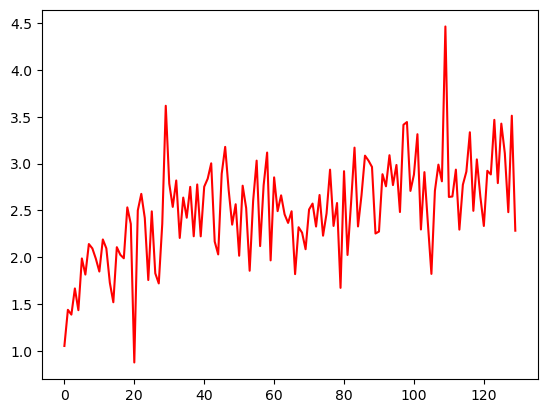

In [50]:
dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))
batch_size = 64
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model =  MINE(zd_dim=32)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
epochs = 100
mi_est_values = []
test_mi_est_values = []
test_mean_mi_est_values = []
step = 0
for epoch in tqdm(range(epochs), 'epoch'):
            # rho = mi_to_rho(mi_value, sample_dim)
            for batch_x, batch_y, batch_label in train_loader:
                # print(batch_x.shape)
                # print(batch_y.shape)
            # for step in tqdm(range(training_steps), 'Training Loop', position=0, leave=True):
            #     batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size=batch_size,
            #                                                     to_cuda=torch.cuda.is_available(), cubic=cubic)
                # batch_x = torch.tensor(batch_x).float().to(device)
                # batch_y = torch.tensor(batch_y).float().to(device)
                model.eval()
                mi_est, _, _ = model(batch_x, batch_y, batch_label)
                mi_est_values.append(mi_est.item())
                print('train ', mi_est)
                model.train()

                model_loss = model.learning_loss(batch_x, batch_y, batch_label)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()

                del batch_x, batch_y, batch_label
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                step += 1
                if step % 50 == 0:
                    step = 0
                    with torch.no_grad():
                        s = 0.
                        n = 0
                        for batch_x, batch_y, batch_label in test_loader:
                            n += 1
                            model.eval()
                            mi_est, _, _ = model(batch_x, batch_y, batch_label)
                            s += mi_est
                            print('test ', mi_est )
                            test_mi_est_values.append(mi_est.item())
                        
                        test_mean_mi_est_values.append(s/n)
                    del batch_x, batch_y, batch_label

            #print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
            # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # end_time = time.time()
        # time_cost = end_time - start_time
        # print("model %s average time cost is %f s" % (model_name, time_cost / total_steps))
        # mi_results[model_name] = mi_est_values
        # plt.plot(mi_est_values)
        # plt.plot(test_mi_est_values)
plt.plot(test_mean_mi_est_values,color='r')
plt.show()

In [13]:
class CLUB(nn.Module):  # CLUB: Mutual Information Contrastive Learning Upper Bound
    '''
        This class provides the CLUB estimation to I(X,Y)
        Method:
            forward() :      provides the estimation with input samples
            loglikeli() :   provides the log-likelihood of the approximation q(Y|X) with input samples
        Arguments:
            zc_dim, zd_dim :         the dimensions of samples from X, Y respectively
            hidden_size :          the dimension of the hidden layer of the approximation network q(Y|X)
            z_c, z_d : samples from X and Y, having shape [sample_size, zc_dim/zd_dim]
    '''

    def __init__(self, zc_dim, zd_dim): # args,
        super(CLUB, self).__init__()
        self.use_tanh = False
        # self.p_mu = FF(args, zc_dim, zc_dim, zd_dim)
        # self.p_logvar = FF(args, zc_dim, zc_dim, zd_dim)
        self.p_mu = nn.Sequential(nn.Linear(zc_dim, zd_dim),
                                      nn.ReLU(),
                                      nn.Linear(zd_dim, zd_dim),
                                    )
        self.p_logvar = nn.Sequential(nn.Linear(zc_dim, zd_dim),
                                      nn.ReLU(),
                                      nn.Linear(zd_dim, zd_dim),
                                      nn.Tanh())

    def get_mu_logvar(self, z_c):
        mu = self.p_mu(z_c)
        logvar = self.p_logvar(z_c)
        if self.use_tanh:
            logvar = logvar.tanh()
        return mu, logvar

    def forward(self, z_c, z_d):
        mu, logvar = self.get_mu_logvar(z_c)

        # log of conditional probability of positive sample pairs
        positive = - (mu - z_d) ** 2 / 2. / logvar.exp()

        prediction_1 = mu.unsqueeze(1)  # shape [nsample,1,dim]
        z_d_1 = z_d.unsqueeze(0)  # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((z_d_1 - prediction_1) ** 2).mean(dim=1) / 2. / logvar.exp()
        mi = (positive.sum(-1) - negative.sum(-1)).mean()
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d):  # unnormalized loglikelihood
        mu, logvar = self.get_mu_logvar(z_c)
        return -(-(mu - z_d) ** 2 / logvar.exp() - logvar).sum(1).mean(0)

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]


In [14]:
class MyClub(nn.Module):
    def __init__(self,zc_dim, zd_dim, sample=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv = ConvNet()
        if sample:
            # self.club = CLUBSample(x_dim=x_dim, y_dim=y_dim, hidden_size=32)
            self.club = CLUB(zc_dim=zc_dim, zd_dim=zd_dim)
        else:
            self.club = CLUB(zc_dim=zc_dim, zd_dim=zd_dim)

    def get_mu_logvar(self, z_c):
        z_c = self.conv(z_c)
        return self.club.get_mu_logvar(z_c)

    def forward(self, z_c, z_d):
        mu, logvar = self.get_mu_logvar(z_c)

        # log of conditional probability of positive sample pairs
        positive = - (mu - z_d) ** 2 / 2. / logvar.exp()

        prediction_1 = mu.unsqueeze(1)  # shape [nsample,1,dim]
        z_d_1 = z_d.unsqueeze(0)  # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((z_d_1 - prediction_1) ** 2).mean(dim=1) / 2. / logvar.exp()
        mi = (positive.sum(-1) - negative.sum(-1)).mean()
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d):  # unnormalized loglikelihood
        mu, logvar = self.get_mu_logvar(z_c)
        return -(-(mu - z_d) ** 2 / logvar.exp() - logvar).sum(1).mean(0)

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]

In [15]:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho ** 2)
    return result


def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

In [16]:
import time

In [17]:
from myknife import MyKNIFE

In [18]:
def main(cubic=True):
    # import os
    # os.environ['CUDA_VISIBLE_DEVICES'] = '2'

    #for seed in [1, 2 ,3, 4, 5, 6, 7, 8]:
    # set_seed(seed)
    lambda_ = 2

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    # suffix = '9.07_{}_{}_{}'.format(cubic, lambda_, seed)
    suffix = "test"
    # sample_dim = 20
    batch_size = 64
    # hidden_size = 15
    learning_rate = 0.001
    training_steps = 50_000
    model_list =  ["MyKnife"]# ["MyClub"]  #"TUBA", "KNIFE" # CLUBSample

    mi_list = [2.0] #, 4.0, 6.0, 8.0, 10.0]  # , 12.0, 14.0, 16.0, 18.0, 20.0]

    total_steps = training_steps * len(mi_list)
    
    dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))
    train_ratio = 0.8
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for the training and testing sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_iter = iter(test_loader)
    # train MI estimators with samples

    # train MI estimators with samples

    mi_results = dict()
    for model_name in tqdm(model_list, 'Models'):
        if model_name == "MyClub":
            model = MyClub(zc_dim=32,zd_dim=32)
            model.conv = convnet
        if model_name == "MyKnife":
            model = MyKNIFE(32,4)
            model.kernel_marg = copy.deepcopy(convnet)
            model.kernel_cond = copy.deepcopy(convnet)
        # elif model_name == 'Kernel_F':
        #     model = MIKernelEstimator(device, sample_dim // 2, sample_dim).to(device)
        # elif model_name == 'KNIFE':
        #     model = MIKernelEstimator(device, batch_size // 6, sample_dim, sample_dim, use_joint=True).to(device)
        # elif model_name == 'DOE':
        #     model = eval(model_name)(sample_dim, sample_dim).to(device)
        # else:
        #     model = eval(model_name)(sample_dim, sample_dim, hidden_size).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

        mi_est_values = []
        test_mi_est_values = []
        test_mean_mi_est_values = []
        step = 0
        start_time = time.time()
        epochs = 60
        for epoch in tqdm(range(epochs), 'epoch'):
            # rho = mi_to_rho(mi_value, sample_dim)
            for batch_x, batch_y, batch_label in train_loader:
                # print(batch_x.shape)
                # print(batch_y.shape)
            # for step in tqdm(range(training_steps), 'Training Loop', position=0, leave=True):
            #     batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size=batch_size,
            #                                                     to_cuda=torch.cuda.is_available(), cubic=cubic)
                # batch_x = torch.tensor(batch_x).float().to(device)
                # batch_y = torch.tensor(batch_y).float().to(device)
                model.eval()
                mi_est, _, _ = model(batch_x, batch_y, batch_label)
                mi_est_values.append(mi_est.item())

                model.train()

                model_loss = model.learning_loss(batch_x, batch_y, batch_label)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()

                del batch_x, batch_y, batch_label
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                step += 1
                if step % 50 == 0:
                    step = 0
                    with torch.no_grad():
                        s = 0.
                        n = 0
                        for batch_x, batch_y, batch_label in test_loader:
                            n += 1
                            model.eval()
                            mi_est, _, _ = model(batch_x, batch_y, batch_label)
                            s += mi_est
                            test_mi_est_values.append(mi_est.item())
                        test_mean_mi_est_values.append(s/n)
                    del batch_x, batch_y, batch_label

            #print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
            # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        end_time = time.time()
        time_cost = end_time - start_time
        print("model %s average time cost is %f s" % (model_name, time_cost / total_steps))
        mi_results[model_name] = mi_est_values
        # plt.plot(mi_est_values)
        # plt.plot(test_mi_est_values)
        plt.plot(test_mean_mi_est_values,color='r')
        plt.show()

    import seaborn as sns
    import pandas as pd

    colors = sns.color_palette()

    EMA_SPAN = 200

    ncols = len(model_list)
    nrows = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 * ncols, 3.4 * nrows))
    axs = np.ravel(axs)

    xaxis = np.array(list(range(total_steps)))
    yaxis_mi = np.repeat(mi_list, training_steps)

    for i, model_name in enumerate(model_list):
        plt.sca(axs[i])
        p1 = plt.plot(mi_results[model_name], alpha=0.4, color=colors[0])[0]  # color = 5 or 0
        plt.locator_params(axis='y', nbins=5)
        plt.locator_params(axis='x', nbins=4)
        mis_smooth = pd.Series(mi_results[model_name]).ewm(span=EMA_SPAN).mean()

        if i == 0:
            plt.plot(mis_smooth, c=p1.get_color(), label='$\\hat{I}$')
            plt.plot(yaxis_mi, color='k', label='True')
            plt.xlabel('Steps', fontsize=25)
            plt.ylabel('MI', fontsize=25)
            plt.legend(loc='upper left', prop={'size': 15})
        else:
            plt.plot(mis_smooth, c=p1.get_color())
            plt.yticks([])
            plt.plot(yaxis_mi, color='k')
            plt.xlabel('Steps', fontsize=25)

        # plt.ylim(0, 15.5)
        plt.xlim(0, total_steps)
        plt.title(model_name, fontsize=35)
        import matplotlib.ticker as ticker

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        plt.xticks(horizontalalignment="right")
        # plt.subplots_adjust( )

    plt.gcf().tight_layout()
    # plt.savefig('mi_est_Gaussian_{}_copy.pdf'.format(suffix), bbox_inches=None)
    # plt.show()

    print('Second part')

    bias_dict = dict()
    var_dict = dict()
    mse_dict = dict()
    for i, model_name in tqdm(enumerate(model_list)):
        bias_list = []
        var_list = []
        mse_list = []
        for j in range(len(mi_list)):
            mi_est_values = mi_results[model_name][training_steps * (j + 1) - 500:training_steps * (j + 1)]
            est_mean = np.mean(mi_est_values)
            bias_list.append(np.abs(mi_list[j] - est_mean))
            var_list.append(np.var(mi_est_values))
            mse_list.append(bias_list[j] ** 2 + var_list[j])
        bias_dict[model_name] = bias_list
        var_dict[model_name] = var_list
        mse_dict[model_name] = mse_list

    # %%

    plt.style.use('default')  # ('seaborn-notebook')

    colors = list(plt.rcParams['axes.prop_cycle'])
    col_idx = [2, 4, 5, 1, 3, 0, 6, 7]

    ncols = 1
    nrows = 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3. * nrows))
    axs = np.ravel(axs)

    for i, model_name in enumerate(model_list):
        plt.sca(axs[0])
        plt.plot(mi_list, bias_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

        plt.sca(axs[1])
        plt.plot(mi_list, var_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

        plt.sca(axs[2])
        plt.plot(mi_list, mse_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

    ylabels = ['Bias', 'Variance', 'MSE']
    for i in range(3):
        plt.sca(axs[i])
        plt.ylabel(ylabels[i], fontsize=15)

        if i == 0:
            if cubic:
                plt.title('Cubic', fontsize=17)
            else:
                plt.title('Gaussian', fontsize=17)
        if i == 1:
            plt.yscale('log')
        if i == 2:
            plt.legend(loc='upper left', prop={'size': 12})
            plt.xlabel('MI Values', fontsize=15)

    plt.gcf().tight_layout()
    # plt.savefig('bias_variance_Gaussian_{}.pdf'.format(suffix), bbox_inches='tight')
    # plt.show()

epoch: 100%|██████████| 60/60 [2:17:35<00:00, 137.58s/it]


model MyKnife average time cost is 0.165101 s


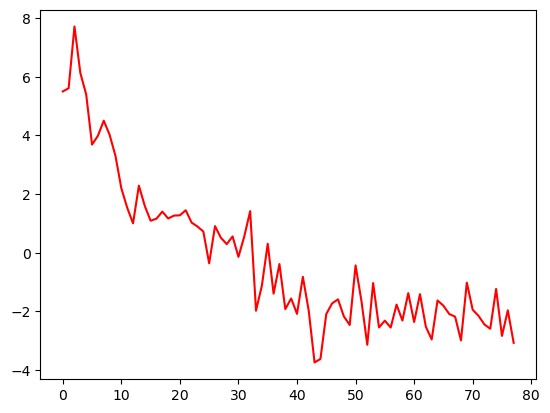

Models: 100%|██████████| 1/1 [2:17:35<00:00, 8255.77s/it]


Second part


0it [00:00, ?it/s]c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
1it [00:00, 124.96it/s]


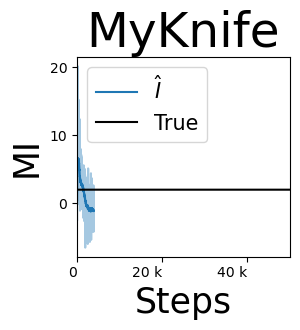

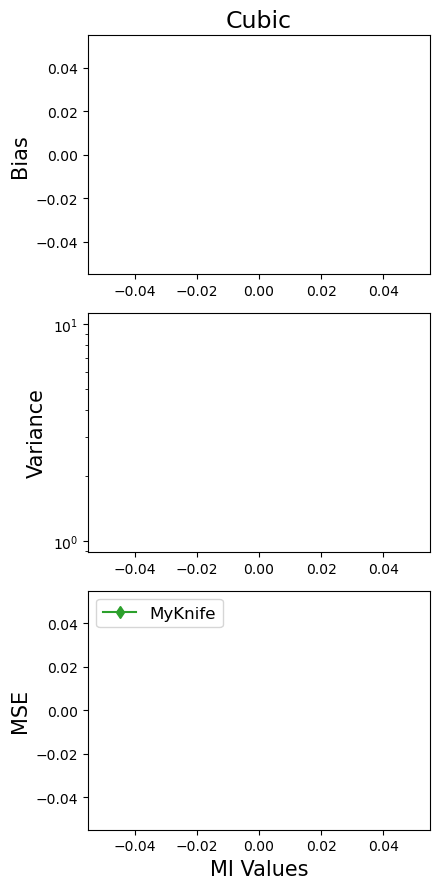

In [19]:
# main()